In [194]:
%matplotlib inline

In [195]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import pickle
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering

## Exploratory Data Analysis

In [196]:
cc_df = pd.read_csv('AnonymousBank/July1999.txt', sep='\t')

cc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39022 entries, 0 to 39021
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   vru+line     39022 non-null  object
 1   call_id      39022 non-null  int64 
 2   customer_id  39022 non-null  int64 
 3   priority     39022 non-null  object
 4   type         39022 non-null  object
 5   date         39022 non-null  object
 6   vru_entry    39022 non-null  object
 7   vru_exit     39022 non-null  object
 8   vru_time     39022 non-null  object
 9   q_start      39022 non-null  object
 10  q_exit       39022 non-null  object
 11  q_time       39022 non-null  object
 12  outcome      39022 non-null  object
 13  ser_start    39022 non-null  object
 14  ser_exit     39022 non-null  object
 15  ser_time     39022 non-null  object
 16  server       39017 non-null  object
dtypes: int64(2), object(15)
memory usage: 5.1+ MB


C:\Users\irfan\AppData\Local\Temp\ipykernel_30324\174240284.py:1: DtypeWarning: Columns (3,5,8,11,15) have mixed types. Specify dtype option on import or set low_memory=False.
  cc_df = pd.read_csv('AnonymousBank/July1999.txt', sep='\t')


In [197]:
# Display the first few rows of the DataFrame
cc_df.head()

,vru+line,call_id,customer_id,priority,type,date,vru_entry,vru_exit,vru_time,q_start,q_exit,q_time,outcome,ser_start,ser_exit,ser_time,server
0,AA0101,41886,0,0,PS,990701,0:26:17,0:26:27,10,0:00:00,0:00:00,0,HANG,0:00:00,0:00:00,0,NO_SERVER
1,AA0101,41887,0,0,NW,990701,6:58:10,6:58:20,10,6:58:20,6:59:08,48,AGENT,6:59:07,6:59:15,8,MORIAH
2,AA0101,41888,0,0,PS,990701,7:30:27,7:30:35,8,0:00:00,0:00:00,0,AGENT,7:30:35,7:34:16,221,MORIAH
3,AA0101,41889,22800312,2,PS,990701,7:49:32,7:49:37,5,7:49:37,7:50:27,50,AGENT,7:50:26,7:51:48,82,ANAT
4,AA0101,41890,0,0,PS,990701,8:03:56,8:04:08,12,0:00:00,0:00:00,0,AGENT,8:04:07,8:05:25,78,KAZAV


In [198]:
# Check broken parsing
# Check if any 'type' values are not 2 characters long
cc_df[cc_df['type'].str.len() != 2]

,vru+line,call_id,customer_id,priority,type,date,vru_entry,vru_exit,vru_time,q_start,q_exit,q_time,outcome,ser_start,ser_exit,ser_time,server
9142,AA0108,3364,0,0 TT,990717,2:17:57,2:18:09,12,0:00:00,0:00:00,0,HANG,0:00:00,0:00:00,0,NO_SERVER,NaN
9236,AA0108,3458,0,0 TT,990729,9:16:11,9:16:27,16,0:00:00,0:00:00,0,HANG,0:00:00,0:00:00,0,NO_SERVER,NaN
12078,AA0111,3590,0,0 TT,990703,13:56:19,13:56:22,3,0:00:00,0:00:00,0,HANG,0:00:00,0:00:00,0,NO_SERVER,NaN
15210,AA0116,6178,0,0 IN,990706,12:02:11,12:02:34,23,0:00:00,0:00:00,0,HANG,0:00:00,0:00:00,0,NO_SERVER,NaN
15388,AA0116,6357,0,0 IN,990719,19:26:18,19:26:24,6,0:00:00,0:00:00,0,HANG,0:00:00,0:00:00,0,NO_SERVER,NaN


In [199]:
# Since these have 'HANG' outcome, let's just drop these rows
cc_df = cc_df[cc_df['type'].str.len() == 2]

cc_df[cc_df['type'].str.len() != 2]

,vru+line,call_id,customer_id,priority,type,date,vru_entry,vru_exit,vru_time,q_start,q_exit,q_time,outcome,ser_start,ser_exit,ser_time,server


In [200]:
# Change date column types to datetime
cc_df['date'] = pd.to_datetime(cc_df['date'], format='%y%m%d')

# Change time columns to datetime
cc_df['vru_entry'] = pd.to_datetime(cc_df['date'].astype(str) + ' ' + cc_df['vru_entry'], format='%Y-%m-%d %H:%M:%S')
cc_df['vru_exit'] = pd.to_datetime(cc_df['date'].astype(str) + ' ' + cc_df['vru_exit'], format='%Y-%m-%d %H:%M:%S')
cc_df['ser_start'] = pd.to_datetime(cc_df['date'].astype(str) + ' ' + cc_df['ser_start'], format='%Y-%m-%d %H:%M:%S')
cc_df['ser_exit'] = pd.to_datetime(cc_df['date'].astype(str) + ' ' + cc_df['ser_exit'], format='%Y-%m-%d %H:%M:%S')

# Change number columns to numeric
cc_df['vru_time'] = pd.to_numeric(cc_df['vru_time'], errors='coerce')
cc_df['q_time'] = pd.to_numeric(cc_df['q_time'], errors='coerce')
cc_df['ser_time'] = pd.to_numeric(cc_df['ser_time'], errors='coerce')

# Only keep rows with 'AGENT' in the 'outcome' column
cc_df = cc_df[cc_df['outcome'] == 'AGENT']

# Remove calls coming later than midnight and earlier than 7 AM
cc_df = cc_df[(cc_df['vru_entry'].dt.hour >= 7) & (cc_df['vru_entry'].dt.hour < 24)]

# Remove calls with 'NO_SERVER' server
cc_df = cc_df[cc_df['server'] != 'NO_SERVER']

# Remove calls with more than 1 hour, and less than 5 seconds of service time.
cc_df = cc_df[cc_df['ser_time'] <= 3600]
cc_df = cc_df[cc_df['ser_time'] > 5]

# Drop unnecessary columns
cc_df = cc_df.drop(columns=['vru+line', 'customer_id', 'priority'])

# Display the first few rows of the cleaned DataFrame
cc_df.head()

,call_id,type,date,vru_entry,vru_exit,vru_time,q_start,q_exit,q_time,outcome,ser_start,ser_exit,ser_time,server
2,41888,PS,1999-07-01,1999-07-01 07:30:27,1999-07-01 07:30:35,8,0:00:00,0:00:00,0,AGENT,1999-07-01 07:30:35,1999-07-01 07:34:16,221,MORIAH
3,41889,PS,1999-07-01,1999-07-01 07:49:32,1999-07-01 07:49:37,5,7:49:37,7:50:27,50,AGENT,1999-07-01 07:50:26,1999-07-01 07:51:48,82,ANAT
4,41890,PS,1999-07-01,1999-07-01 08:03:56,1999-07-01 08:04:08,12,0:00:00,0:00:00,0,AGENT,1999-07-01 08:04:07,1999-07-01 08:05:25,78,KAZAV
5,41891,PS,1999-07-01,1999-07-01 08:22:12,1999-07-01 08:22:25,13,0:00:00,0:00:00,0,AGENT,1999-07-01 08:22:24,1999-07-01 08:32:12,588,YIFAT
6,41892,PS,1999-07-01,1999-07-01 08:32:24,1999-07-01 08:32:29,5,8:32:29,8:32:45,16,AGENT,1999-07-01 08:32:44,1999-07-01 08:33:39,55,TOVA


In [201]:
# Count the number of row after cleaning
print(f"Number of rows after cleaning: {len(cc_df)}")

Number of rows after cleaning: 27806


In [202]:
# Count the number of unique agents
cc_df['server'].nunique()

25

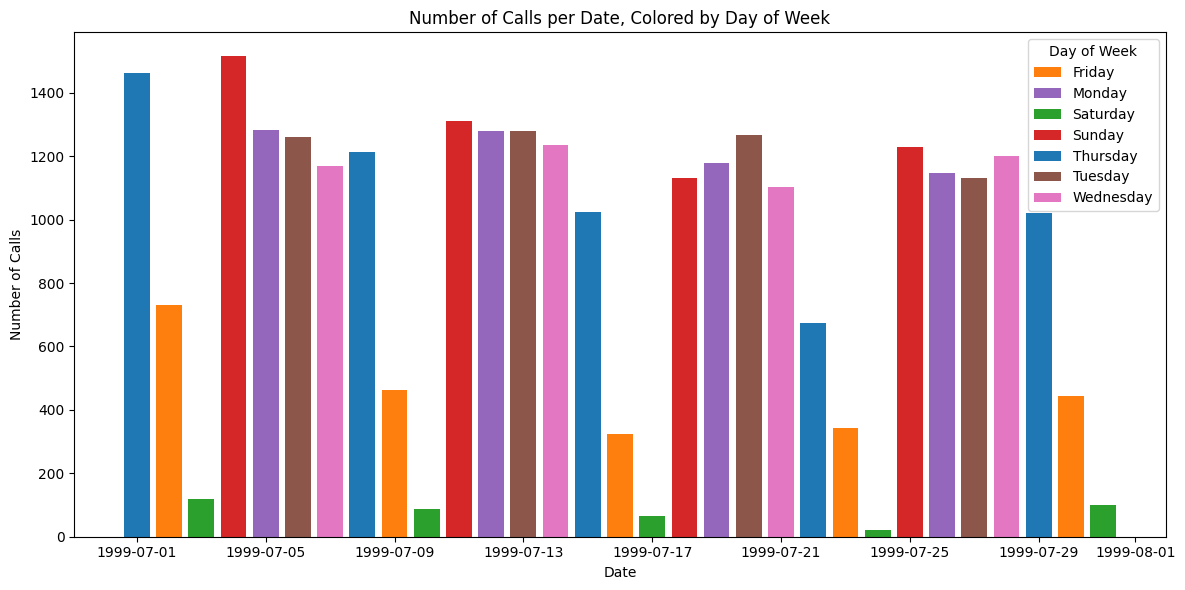

In [203]:
# Count the rows for each date

# Add day of week
cc_df['day_of_week'] = cc_df['date'].dt.day_name()
# Count the rows for each date and color by day of week
date_counts = cc_df.groupby(['date', 'day_of_week']).size().reset_index(name='count')
day_colors = dict(zip(cc_df['day_of_week'].unique(), sns.color_palette('tab10', n_colors=cc_df['day_of_week'].nunique())))
plt.figure(figsize=(12, 6))
for day, group in date_counts.groupby('day_of_week'):
    plt.bar(group['date'], group['count'], color=day_colors[day], label=day)
plt.xlabel('Date')
plt.ylabel('Number of Calls')
plt.title('Number of Calls per Date, Colored by Day of Week')
plt.legend(title='Day of Week')
plt.tight_layout()
plt.show()

In [204]:
# Lets analyse the one with highest number of calls, which is 1999-04-11
highest_calls_date = date_counts.loc[date_counts['count'].idxmax(), 'date']
highest_calls_df = cc_df[cc_df['date'] == highest_calls_date]

highest_calls_df

,call_id,type,date,vru_entry,vru_exit,vru_time,q_start,q_exit,q_time,outcome,ser_start,ser_exit,ser_time,server,day_of_week
131,42020,PS,1999-07-04,1999-07-04 07:10:15,1999-07-04 07:10:29,14,0:00:00,0:00:00,0,AGENT,1999-07-04 07:10:28,1999-07-04 07:12:41,133,AVI,Sunday
132,42021,PS,1999-07-04,1999-07-04 07:29:57,1999-07-04 07:30:06,9,0:00:00,0:00:00,0,AGENT,1999-07-04 07:30:05,1999-07-04 07:34:32,267,YIFAT,Sunday
134,42023,PS,1999-07-04,1999-07-04 08:08:12,1999-07-04 08:08:19,7,8:08:19,8:08:40,21,AGENT,1999-07-04 08:08:39,1999-07-04 08:13:10,271,VICKY,Sunday
135,42024,PS,1999-07-04,1999-07-04 08:16:34,1999-07-04 08:16:41,7,8:16:41,8:17:06,25,AGENT,1999-07-04 08:17:04,1999-07-04 08:20:10,186,KAZAV,Sunday
137,42026,PS,1999-07-04,1999-07-04 08:36:44,1999-07-04 08:36:50,6,8:36:50,8:37:25,35,AGENT,1999-07-04 08:37:23,1999-07-04 08:39:37,134,AVI,Sunday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38180,7054,PS,1999-07-04,1999-07-04 16:12:08,1999-07-04 16:12:14,6,16:12:14,16:14:19,125,AGENT,1999-07-04 16:14:18,1999-07-04 16:19:57,339,YITZ,Sunday
38181,7055,IN,1999-07-04,1999-07-04 17:26:08,1999-07-04 17:26:17,9,17:26:17,17:26:35,18,AGENT,1999-07-04 17:26:34,1999-07-04 17:30:13,219,YITZ,Sunday
38183,7057,IN,1999-07-04,1999-07-04 18:56:52,1999-07-04 18:57:01,9,18:57:01,19:04:14,433,AGENT,1999-07-04 19:04:14,1999-07-04 19:04:54,40,TOVA,Sunday
38184,7058,IN,1999-07-04,1999-07-04 19:36:13,1999-07-04 19:36:27,14,0:00:00,0:00:00,0,AGENT,1999-07-04 19:36:26,1999-07-04 19:43:48,442,TOVA,Sunday


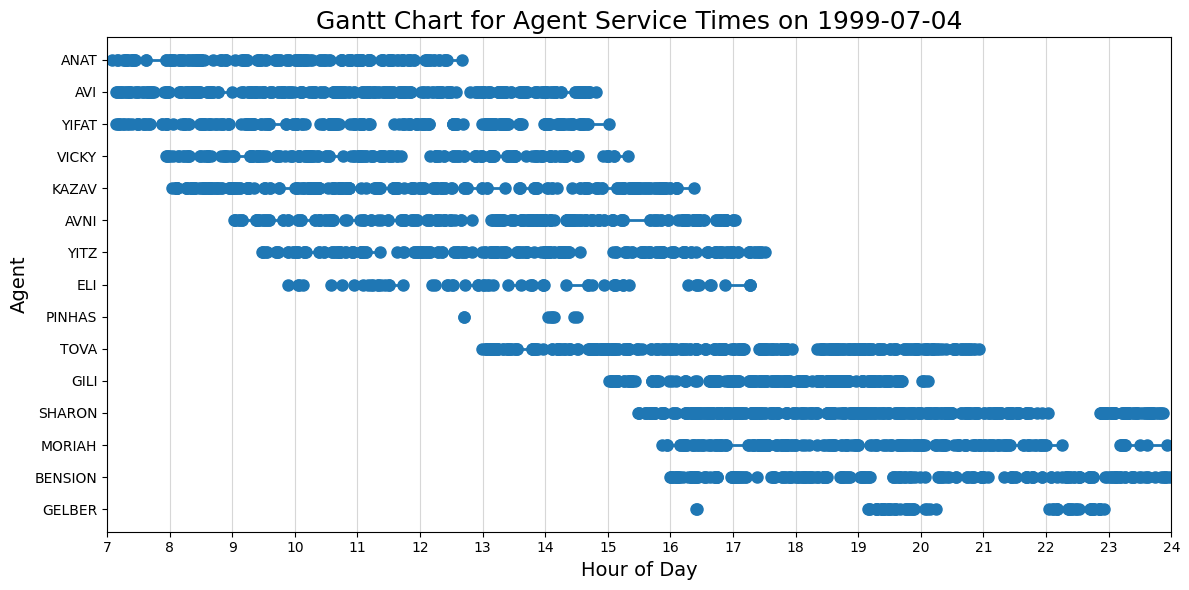

In [205]:
# Remove calls in service later than midnight and earlier than 7 AM
highest_calls_df = highest_calls_df[(highest_calls_df['ser_exit'].dt.hour >= 7) & (highest_calls_df['ser_exit'].dt.hour < 24)]

# Gantt chart for agents service times
# Assign a y position for each agent
agent_order = highest_calls_df['server'].unique()
# Sort agents by the first service start time
agent_order = highest_calls_df.groupby('server')['ser_start'].min().sort_values(ascending=False).index.to_numpy()
agent_to_y = {agent: i for i, agent in enumerate(agent_order)}

plt.figure(figsize=(12, 6))
for _, row in highest_calls_df.iterrows():
    y = agent_to_y[row['server']]
    x_start = row['ser_start'].hour + row['ser_start'].minute / 60 + row['ser_start'].second / 3600
    x_end = row['ser_exit'].hour + row['ser_exit'].minute / 60 + row['ser_exit'].second / 3600
    plt.hlines(y, x_start, x_end, color='tab:blue', linewidth=2)
    plt.plot([x_start, x_end], [y, y], 'o', color='tab:blue', markersize=8)  # blue dots

plt.xlabel('Hour of Day', fontsize=14)
plt.ylabel('Agent', fontsize=14)
plt.title(f'Gantt Chart for Agent Service Times on {highest_calls_date.date()}', fontsize=18)
plt.xlim(7, 24)
plt.xticks(range(7, 25))
plt.yticks(range(len(agent_order)), agent_order)
plt.grid(True, axis='x', alpha=0.5)
plt.tight_layout()
plt.show()

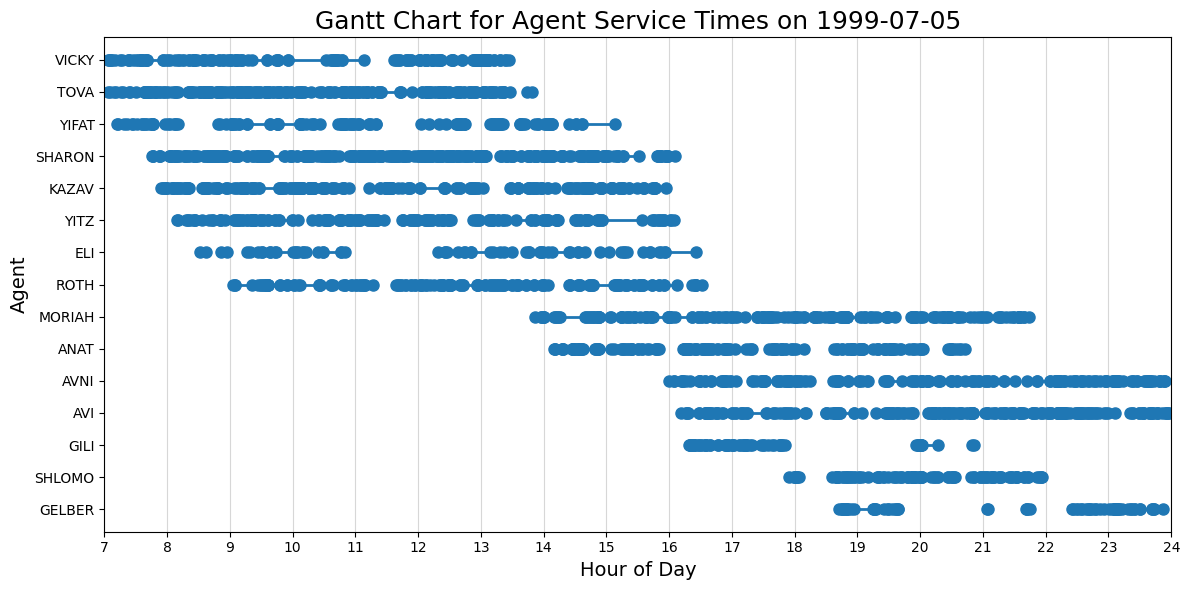

In [206]:
# Create gantt chart for the next day
next_day = highest_calls_date + pd.Timedelta(days=1)
next_day_df = cc_df[cc_df['date'] == next_day]

# Remove calls in service later than midnight and earlier than 7 AM
next_day_df = next_day_df[(next_day_df['ser_exit'].dt.hour >= 7) & (next_day_df['ser_exit'].dt.hour < 24)]

# Gantt chart for agents service times
# Assign a y position for each agent
agent_order_next = next_day_df['server'].unique()
agent_order_next = next_day_df.groupby('server')['ser_start'].min().sort_values(ascending=False).index.to_numpy()
agent_to_y_next = {agent: i for i, agent in enumerate(agent_order_next)}

plt.figure(figsize=(12, 6))
for _, row in next_day_df.iterrows():
    y = agent_to_y_next[row['server']]
    x_start = row['ser_start'].hour + row['ser_start'].minute / 60 + row['ser_start'].second / 3600
    x_end = row['ser_exit'].hour + row['ser_exit'].minute / 60 + row['ser_exit'].second / 3600
    plt.hlines(y, x_start, x_end, color='tab:blue', linewidth=2)
    plt.plot([x_start, x_end], [y, y], 'o', color='tab:blue', markersize=8)  # blue dots

plt.xlabel('Hour of Day', fontsize=14)
plt.ylabel('Agent', fontsize=14)
plt.title(f'Gantt Chart for Agent Service Times on {next_day.date()}', fontsize=18)
plt.xlim(7, 24)
plt.xticks(range(7, 25))
plt.yticks(range(len(agent_order_next)), agent_order_next)
plt.grid(True, axis='x', alpha=0.5)
plt.tight_layout()
plt.show()

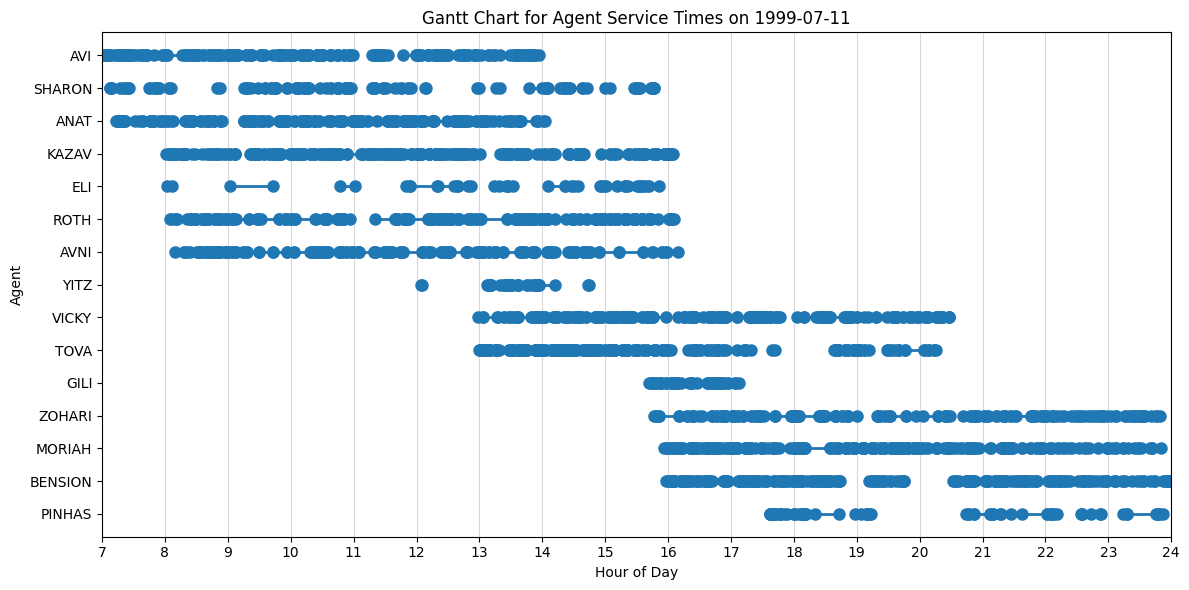

In [207]:
# Gantt chart for a week after the highest calls date
week_after_date = highest_calls_date + pd.Timedelta(days=7)
week_after_df = cc_df[(cc_df['date'] == week_after_date)]

# Remove calls in service later than midnight and earlier than 7 AM
week_after_df = week_after_df[(week_after_df['ser_exit'].dt.hour >= 7) & (week_after_df['ser_exit'].dt.hour < 24)]

# Gantt chart for agents service times
# Assign a y position for each agent
agent_order_week = week_after_df['server'].unique()
agent_order_week = week_after_df.groupby('server')['ser_start'].min().sort_values(ascending=False).index.to_numpy()
agent_to_y_week = {agent: i for i, agent in enumerate(agent_order_week)}

plt.figure(figsize=(12, 6))
for _, row in week_after_df.iterrows():
    y = agent_to_y_week[row['server']]
    x_start = row['ser_start'].hour + row['ser_start'].minute / 60 + row['ser_start'].second / 3600
    x_end = row['ser_exit'].hour + row['ser_exit'].minute / 60 + row['ser_exit'].second / 3600
    plt.hlines(y, x_start, x_end, color='tab:blue', linewidth=2)
    plt.plot([x_start, x_end], [y, y], 'o', color='tab:blue', markersize=8)  # blue dots

plt.xlabel('Hour of Day')
plt.ylabel('Agent')
plt.title(f'Gantt Chart for Agent Service Times on {week_after_date.date()}')
plt.xlim(7, 24)
plt.xticks(range(7, 25))
plt.yticks(range(len(agent_order_week)), agent_order_week)
plt.grid(True, axis='x', alpha=0.5)
plt.tight_layout()
plt.show()

### So different agents work at different times. But there are always 8 of them at one time

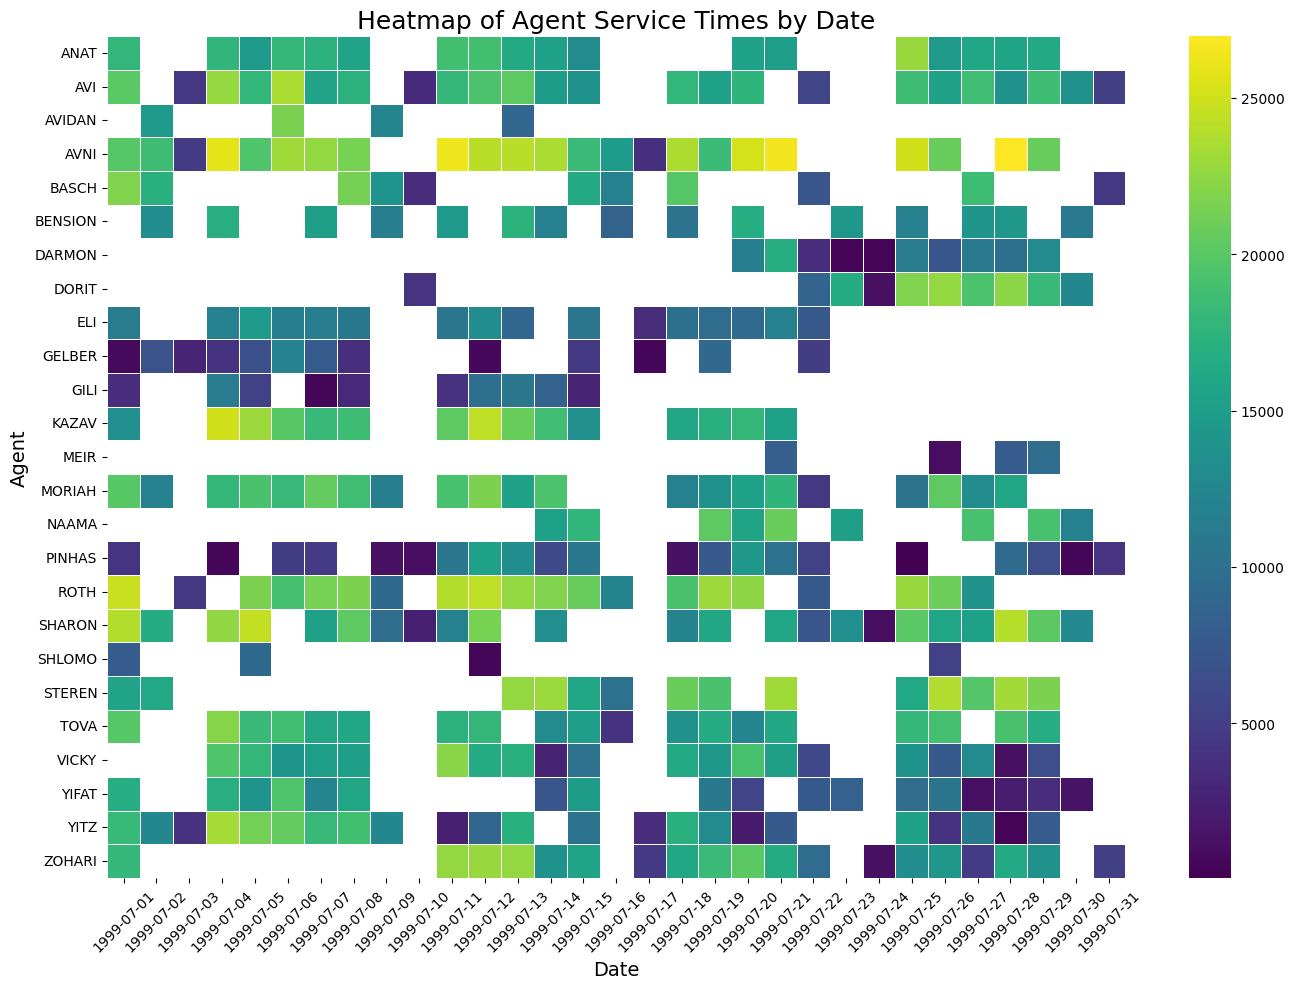

In [208]:
# Ensure 'date' is string before pivoting, for correct heatmap axis labeling
cc_df['date_str'] = cc_df['date'].astype(str)
heatmap_data = cc_df.pivot_table(
    index='server',
    columns='date_str',
    values='ser_time',
    aggfunc='sum'
)

# Now plot, with string labels as columns
plt.figure(figsize=(14, 10))
sns.heatmap(heatmap_data, cmap='viridis', annot=False, fmt='.1f', linewidths=.5)
plt.title('Heatmap of Agent Service Times by Date', fontsize=18)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Agent', fontsize=14)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

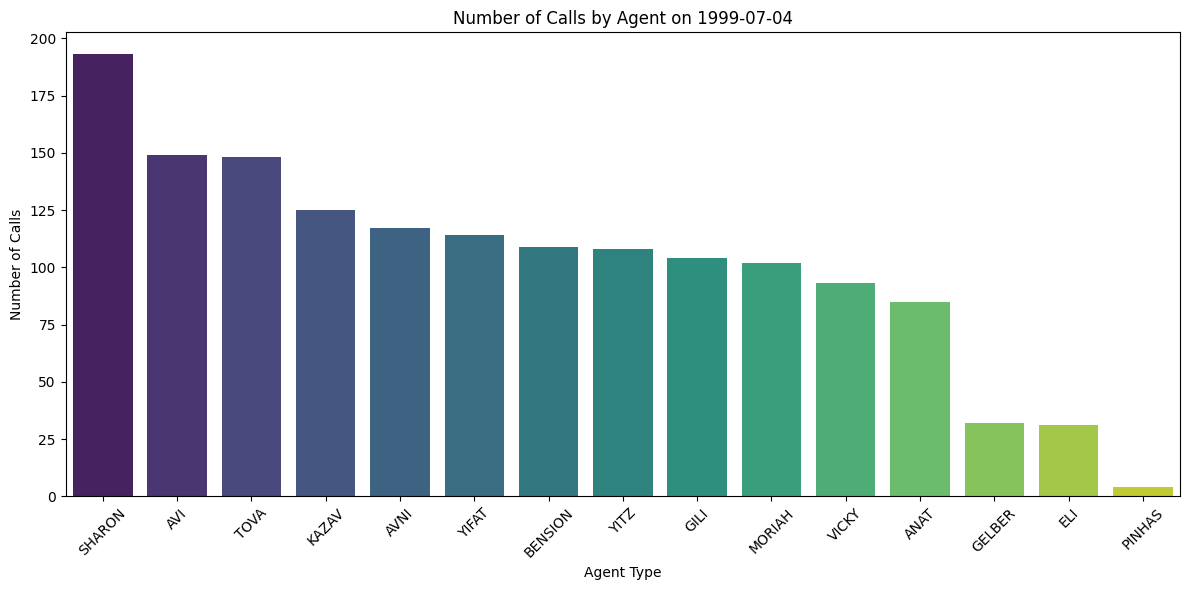

In [209]:
# Check the number of calls performed by each agent
agent_counts = highest_calls_df['server'].value_counts().reset_index()
agent_counts.columns = ['server', 'count']
plt.figure(figsize=(12, 6))
sns.barplot(x='server', y='count', data=agent_counts, palette='viridis', hue='server')
plt.xlabel('Agent Type')
plt.ylabel('Number of Calls')
plt.title(f'Number of Calls by Agent on {highest_calls_date.strftime("%Y-%m-%d")}')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


No assignment pattern so we have to split manually or do clustering

### Let's split the call types into two types (regular and specific)

In [210]:
cc_df['ser_time'].describe()

count    27806.000000
mean       191.602496
std        227.986653
min          6.000000
25%         67.000000
50%        122.000000
75%        228.000000
max       3594.000000
Name: ser_time, dtype: float64

In [211]:
# Group the data by type and calculate the number of calls per type
cc_df_grouped = cc_df.groupby('type')

cc_df_grouped_count = cc_df_grouped.size().reset_index(name='count')
cc_df_grouped_count = cc_df_grouped_count.sort_values(by='count', ascending=False)

# Display the counts of each call type
cc_df_grouped_count

,type,count
4,PS,20497
2,NW,3055
1,NE,2823
5,TT,738
0,IN,607
3,PE,86


In [212]:
# Display the first few rows of the grouped DataFrame
cc_df_grouped.head()

,call_id,type,date,vru_entry,vru_exit,vru_time,q_start,q_exit,q_time,outcome,ser_start,ser_exit,ser_time,server,day_of_week,date_str
2,41888,PS,1999-07-01,1999-07-01 07:30:27,1999-07-01 07:30:35,8,0:00:00,0:00:00,0,AGENT,1999-07-01 07:30:35,1999-07-01 07:34:16,221,MORIAH,Thursday,1999-07-01
3,41889,PS,1999-07-01,1999-07-01 07:49:32,1999-07-01 07:49:37,5,7:49:37,7:50:27,50,AGENT,1999-07-01 07:50:26,1999-07-01 07:51:48,82,ANAT,Thursday,1999-07-01
4,41890,PS,1999-07-01,1999-07-01 08:03:56,1999-07-01 08:04:08,12,0:00:00,0:00:00,0,AGENT,1999-07-01 08:04:07,1999-07-01 08:05:25,78,KAZAV,Thursday,1999-07-01
5,41891,PS,1999-07-01,1999-07-01 08:22:12,1999-07-01 08:22:25,13,0:00:00,0:00:00,0,AGENT,1999-07-01 08:22:24,1999-07-01 08:32:12,588,YIFAT,Thursday,1999-07-01
6,41892,PS,1999-07-01,1999-07-01 08:32:24,1999-07-01 08:32:29,5,8:32:29,8:32:45,16,AGENT,1999-07-01 08:32:44,1999-07-01 08:33:39,55,TOVA,Thursday,1999-07-01
12,41898,NE,1999-07-01,1999-07-01 10:57:26,1999-07-01 10:57:33,7,10:57:33,10:59:26,113,AGENT,1999-07-01 10:59:26,1999-07-01 11:06:11,405,KAZAV,Thursday,1999-07-01
24,41910,NE,1999-07-01,1999-07-01 12:31:01,1999-07-01 12:31:07,6,12:31:07,12:32:45,98,AGENT,1999-07-01 12:32:44,1999-07-01 12:33:30,46,SHARON,Thursday,1999-07-01
25,41911,NE,1999-07-01,1999-07-01 12:40:21,1999-07-01 12:40:26,5,12:40:26,12:40:42,16,AGENT,1999-07-01 12:40:41,1999-07-01 12:44:20,219,SHARON,Thursday,1999-07-01
29,41915,NE,1999-07-01,1999-07-01 13:17:05,1999-07-01 13:17:11,6,13:17:11,13:17:30,19,AGENT,1999-07-01 13:17:28,1999-07-01 13:18:01,33,BASCH,Thursday,1999-07-01
30,41916,NE,1999-07-01,1999-07-01 13:30:13,1999-07-01 13:30:19,6,13:30:19,13:30:53,34,AGENT,1999-07-01 13:30:52,1999-07-01 13:32:59,127,ANAT,Thursday,1999-07-01


Text(0.5, 1.0, 'Number of Calls per Type')

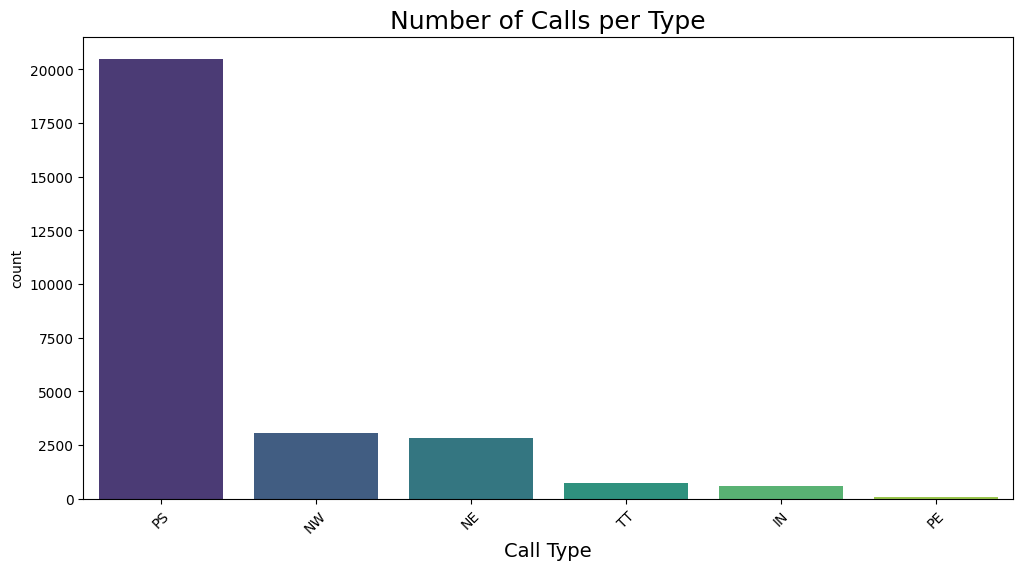

In [213]:
# Plot the number of calls per type
plt.figure(figsize=(12, 6))
sns.barplot(x='type', y='count', data=cc_df_grouped_count, palette='viridis', hue='type')
plt.xlabel('Call Type', fontsize=14)
plt.xticks(rotation=45)
plt.title('Number of Calls per Type', fontsize=18)

In [214]:
# Describe service times of each type dataframes
cc_df_grouped['ser_time'].describe()

,count,mean,std,min,25%,50%,75%,max
type,,,,,,,,
IN,607.0,266.790774,435.892806,6.0,71.00,131.0,252.00,3594.0
NE,2823.0,261.149132,293.475973,6.0,89.00,172.0,318.00,2925.0
NW,3055.0,133.314566,180.263916,6.0,43.00,79.0,156.00,2864.0
PE,86.0,343.372093,400.933148,8.0,145.75,240.0,423.25,3170.0
PS,20497.0,190.265649,210.577896,6.0,71.00,124.0,228.00,2889.0
TT,738.0,124.460705,209.938414,6.0,16.00,62.0,150.75,2677.0


In [215]:
# Check the rows with the longest service times for each type
longest_service_times = cc_df.loc[cc_df_grouped['ser_time'].idxmax()]
longest_service_times

,call_id,type,date,vru_entry,vru_exit,vru_time,q_start,q_exit,q_time,outcome,ser_start,ser_exit,ser_time,server,day_of_week,date_str
38977,7853,IN,1999-07-29,1999-07-29 19:35:24,1999-07-29 19:35:56,32,0:00:00,0:00:00,0,AGENT,1999-07-29 19:35:55,1999-07-29 20:35:49,3594,YITZ,Thursday,1999-07-29
24452,45539,NE,1999-07-06,1999-07-06 12:32:08,1999-07-06 12:32:18,10,0:00:00,0:00:00,0,AGENT,1999-07-06 12:32:18,1999-07-06 13:21:03,2925,ELI,Tuesday,1999-07-06
16387,43020,NW,1999-07-28,1999-07-28 15:43:03,1999-07-28 15:43:12,9,15:43:12,15:45:43,151,AGENT,1999-07-28 15:45:42,1999-07-28 16:33:26,2864,PINHAS,Wednesday,1999-07-28
8524,44346,PE,1999-07-27,1999-07-27 23:03:05,1999-07-27 23:03:09,4,23:03:09,23:04:53,104,AGENT,1999-07-27 23:04:51,1999-07-27 23:57:41,3170,YITZ,Tuesday,1999-07-27
37871,22702,PS,1999-07-27,1999-07-27 15:19:23,1999-07-27 15:19:29,6,15:19:29,15:20:30,61,AGENT,1999-07-27 15:20:30,1999-07-27 16:08:39,2889,NAAMA,Tuesday,1999-07-27
8824,4241,TT,1999-07-13,1999-07-13 22:21:05,1999-07-13 22:21:07,2,0:00:00,0:00:00,0,AGENT,1999-07-13 22:21:06,1999-07-13 23:05:43,2677,PINHAS,Tuesday,1999-07-13


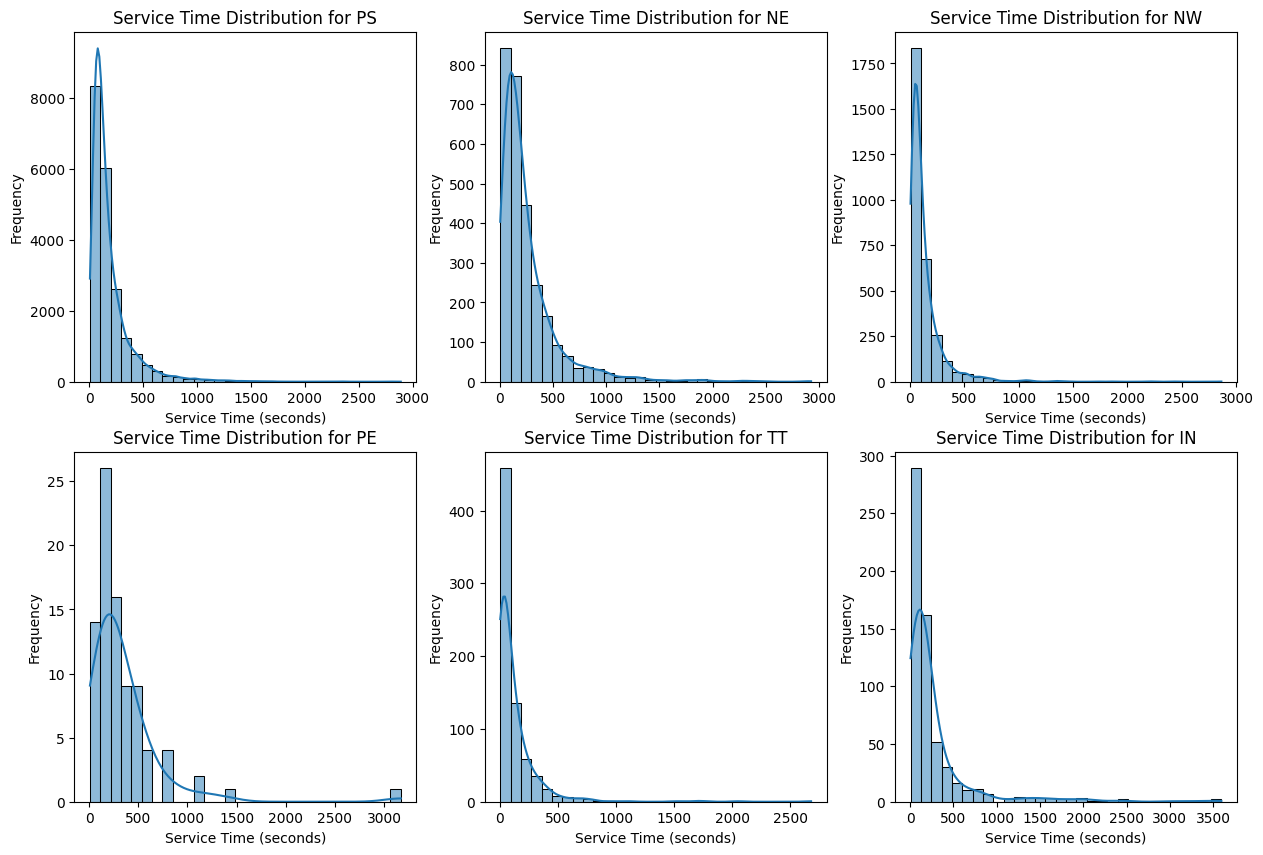

In [216]:
# Plot histogram of service times for each call type
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes = axes.flatten()
for i, call_type in enumerate(cc_df['type'].unique()):
    sns.histplot(cc_df[cc_df['type'] == call_type]['ser_time'], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f'Service Time Distribution for {call_type}')
    axes[i].set_xlabel('Service Time (seconds)')
    axes[i].set_ylabel('Frequency')

In [217]:
# QQ plot against exponential distribution
def qq_plot_exp(data, title):
    stats.probplot(data, dist="expon", plot=plt)
    plt.title(title)
    plt.xlabel('Theoretical Quantiles')
    plt.ylabel('Sample Quantiles')
    
# QQ plot against lognormal distribution
def qq_plot_lognorm(data, title):
    shape, loc, scale = stats.lognorm.fit(data, floc=0)
    stats.probplot(data, dist="lognorm", sparams=(shape, loc, scale), plot=plt)
    plt.title(title)
    plt.xlabel('Theoretical Quantiles')
    plt.ylabel('Sample Quantiles')

In [218]:
def ks_test_distributions_df(data):
    results = {}

    # Exponential: fit with data mean
    exp_params = (data.mean(),)
    d_exp, p_exp = stats.kstest(data, 'expon', args=exp_params)
    results['exponential'] = {'D-statistic': d_exp, 'p-value': p_exp}

    # Gamma: fit distribution to data
    gamma_params = stats.gamma.fit(data)
    d_gamma, p_gamma = stats.kstest(data, 'gamma', args=gamma_params)
    results['gamma'] = {'D-statistic': d_gamma, 'p-value': p_gamma}

    # Lognormal: fit distribution to data
    lognorm_params = stats.lognorm.fit(data)
    d_lognorm, p_lognorm = stats.kstest(data, 'lognorm', args=lognorm_params)
    results['lognormal'] = {'D-statistic': d_lognorm, 'p-value': p_lognorm}
    
    # Weibull: fit distribution to data
    weibull_params = stats.weibull_min.fit(data)
    d_weibull, p_weibull = stats.kstest(data, 'weibull_min', args=weibull_params)
    results['weibull'] = {'D-statistic': d_weibull, 'p-value': p_weibull}

    # Create DataFrame from results
    df = pd.DataFrame(results).T
    df['reject_null'] = df['p-value'] < 0.05

    # Find best fitting distribution
    best_fit = df['p-value'].idxmax()
    df['best_fit'] = best_fit
    return df


In [219]:
# Group the other call into one against 'PS'
# Because 'PS' is general query, we will call it 'REGULAR'
cc_type_df = cc_df.copy()
cc_type_df['type_group'] = cc_type_df['type'].apply(lambda x: 'REGULAR' if x == 'PS' else 'SPECIFIC')

# Display the first few rows of the grouped DataFrame
cc_type_df.head()

,call_id,type,date,vru_entry,vru_exit,vru_time,q_start,q_exit,q_time,outcome,ser_start,ser_exit,ser_time,server,day_of_week,date_str,type_group
2,41888,PS,1999-07-01,1999-07-01 07:30:27,1999-07-01 07:30:35,8,0:00:00,0:00:00,0,AGENT,1999-07-01 07:30:35,1999-07-01 07:34:16,221,MORIAH,Thursday,1999-07-01,REGULAR
3,41889,PS,1999-07-01,1999-07-01 07:49:32,1999-07-01 07:49:37,5,7:49:37,7:50:27,50,AGENT,1999-07-01 07:50:26,1999-07-01 07:51:48,82,ANAT,Thursday,1999-07-01,REGULAR
4,41890,PS,1999-07-01,1999-07-01 08:03:56,1999-07-01 08:04:08,12,0:00:00,0:00:00,0,AGENT,1999-07-01 08:04:07,1999-07-01 08:05:25,78,KAZAV,Thursday,1999-07-01,REGULAR
5,41891,PS,1999-07-01,1999-07-01 08:22:12,1999-07-01 08:22:25,13,0:00:00,0:00:00,0,AGENT,1999-07-01 08:22:24,1999-07-01 08:32:12,588,YIFAT,Thursday,1999-07-01,REGULAR
6,41892,PS,1999-07-01,1999-07-01 08:32:24,1999-07-01 08:32:29,5,8:32:29,8:32:45,16,AGENT,1999-07-01 08:32:44,1999-07-01 08:33:39,55,TOVA,Thursday,1999-07-01,REGULAR


In [220]:
cc_type_df_grouped = cc_type_df.groupby('type_group')

cc_type_df_grouped['ser_time'].describe()

,count,mean,std,min,25%,50%,75%,max
type_group,,,,,,,,
REGULAR,20497.0,190.265649,210.577896,6.0,71.0,124.0,228.0,2889.0
SPECIFIC,7309.0,195.351484,270.884990,6.0,52.0,113.0,229.0,3594.0


### Now we need 2 agent groups from 25 agents. Lets see how each agent perform on REGULAR and SPECIFIC calls

### We will perform clustering to group them into two agent groups

In [221]:
# Calculate mean service time for each server and call type (REGULAR, SPECIFIC)
mean_ser_time = cc_type_df.groupby(['server', 'type_group'])['ser_time'].mean().unstack()
mean_ser_time = mean_ser_time.fillna(0)

mean_ser_time

type_group,REGULAR,SPECIFIC
server,,
ANAT,201.696386,192.968000
AVI,152.048441,132.536585
AVIDAN,190.183168,160.136752
AVNI,246.886092,170.630739
BASCH,190.097027,160.258216
BENSION,128.578606,98.235023
DARMON,275.068966,268.532468
DORIT,197.594679,192.779817
ELI,361.764706,438.482192


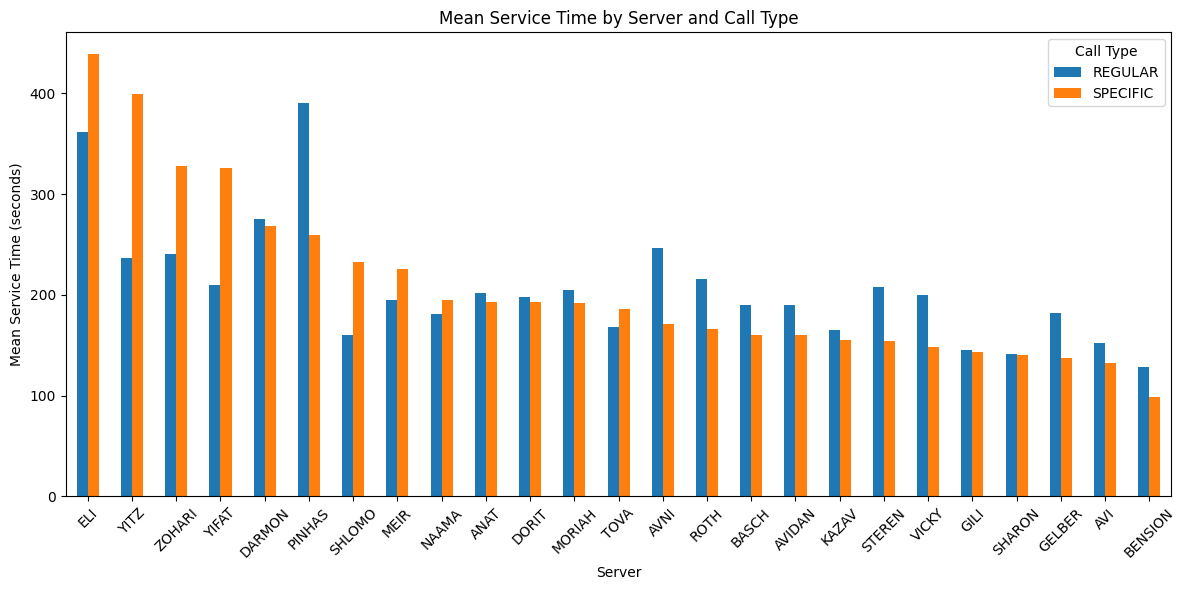

In [222]:
# Plot the mean service times for each server and call type
# Order by highest mean service time
mean_ser_time = mean_ser_time.sort_values(by='SPECIFIC', ascending=False)
plt.figure(figsize=(12, 6))
mean_ser_time.plot(kind='bar', color=['#1f77b4', '#ff7f0e'], ax=plt.gca())
plt.xlabel('Server')
plt.ylabel('Mean Service Time (seconds)')
plt.title('Mean Service Time by Server and Call Type')
plt.legend(title='Call Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

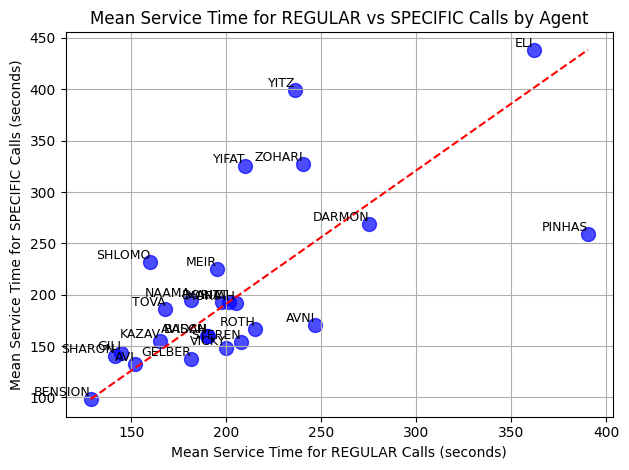

In [223]:
# Define the diagonal
simple_min = mean_ser_time['REGULAR'].min()
simple_max = mean_ser_time['REGULAR'].max()
complex_min = mean_ser_time['SPECIFIC'].min()
complex_max = mean_ser_time['SPECIFIC'].max()

# Create scatterplot of mean service times for each server and call type
plt.figure(figsize=(12, 6))
mean_ser_time.plot(kind='scatter', x='REGULAR', y='SPECIFIC', color='blue', s=100, alpha=0.7)
plt.xlabel('Mean Service Time for REGULAR Calls (seconds)')
plt.ylabel('Mean Service Time for SPECIFIC Calls (seconds)')
plt.title('Mean Service Time for REGULAR vs SPECIFIC Calls by Agent')
# Add middle line (y = x)
plt.plot([simple_min, simple_max],
         [complex_min, complex_max],
         'r--', label='Mean service time')

# Label the dots with server names
for server, row in mean_ser_time.iterrows():
    plt.text(row['REGULAR'], row['SPECIFIC'], server, fontsize=9, ha='right', va='bottom')

# plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [224]:
# Slope and intercept of the diagonal
m = (complex_max - complex_min) / (simple_max - simple_min)
c = complex_min - m * simple_min

# Calculate the y-value on the diagonal for each server's REGULAR mean
diagonal_y = m * mean_ser_time['REGULAR'] + c

# Find servers above and under the line
servers_above = mean_ser_time[mean_ser_time['SPECIFIC'] > diagonal_y]
servers_under = mean_ser_time[mean_ser_time['SPECIFIC'] < diagonal_y]

print("Servers ABOVE the plotted line:")
print(servers_above[['REGULAR', 'SPECIFIC']])

print("\nServers UNDER the plotted line:")
print(servers_under[['REGULAR', 'SPECIFIC']])

Servers ABOVE the plotted line:
type_group     REGULAR    SPECIFIC
server                            
ELI         361.764706  438.482192
YITZ        236.439901  398.989848
ZOHARI      240.498322  327.569191
YIFAT       209.870748  325.383234
SHLOMO      159.908163  232.100000
MEIR        194.906667  225.211538
NAAMA       181.256776  194.736111
DORIT       197.594679  192.779817
TOVA        167.988636  185.709184
KAZAV       165.343028  154.710594
GILI        144.825806  143.030303
SHARON      141.288390  140.680492
AVI         152.048441  132.536585

Servers UNDER the plotted line:
type_group     REGULAR    SPECIFIC
server                            
DARMON      275.068966  268.532468
PINHAS      390.323699  258.890688
ANAT        201.696386  192.968000
MORIAH      204.897230  192.270270
AVNI        246.886092  170.630739
ROTH        215.342667  166.212308
BASCH       190.097027  160.258216
AVIDAN      190.183168  160.136752
STEREN      207.766798  154.043147
VICKY       199.931796  1

In [225]:
# Group the servers into two groups based on their position relative to the diagonal
mean_ser_time['group'] = np.where(mean_ser_time['SPECIFIC'] > diagonal_y, '1', '2')

# Check the grouped means
grouped_means = (
    mean_ser_time.groupby('group')[['REGULAR', 'SPECIFIC']].mean()
)

print(grouped_means)

type_group     REGULAR    SPECIFIC
group                             
1           196.441097  237.839930
2           219.354470  175.625745


In [226]:
mean_ser_time

type_group,REGULAR,SPECIFIC,group
server,,,
ELI,361.764706,438.482192,1
YITZ,236.439901,398.989848,1
ZOHARI,240.498322,327.569191,1
YIFAT,209.870748,325.383234,1
DARMON,275.068966,268.532468,2
PINHAS,390.323699,258.890688,2
SHLOMO,159.908163,232.100000,1
MEIR,194.906667,225.211538,1
NAAMA,181.256776,194.736111,1


In [227]:
# Number of agents in each group
mean_ser_time['group'].value_counts()

group
1    13
2    12
Name: count, dtype: int64

In [228]:
# Apply the grouping to the main dataframe
cc_type_df['group'] = np.where(cc_type_df['server'].isin(servers_above.index), '1', '2')

cc_type_df

,call_id,type,date,vru_entry,vru_exit,vru_time,q_start,q_exit,q_time,outcome,ser_start,ser_exit,ser_time,server,day_of_week,date_str,type_group,group
2,41888,PS,1999-07-01,1999-07-01 07:30:27,1999-07-01 07:30:35,8,0:00:00,0:00:00,0,AGENT,1999-07-01 07:30:35,1999-07-01 07:34:16,221,MORIAH,Thursday,1999-07-01,REGULAR,2
3,41889,PS,1999-07-01,1999-07-01 07:49:32,1999-07-01 07:49:37,5,7:49:37,7:50:27,50,AGENT,1999-07-01 07:50:26,1999-07-01 07:51:48,82,ANAT,Thursday,1999-07-01,REGULAR,2
4,41890,PS,1999-07-01,1999-07-01 08:03:56,1999-07-01 08:04:08,12,0:00:00,0:00:00,0,AGENT,1999-07-01 08:04:07,1999-07-01 08:05:25,78,KAZAV,Thursday,1999-07-01,REGULAR,1
5,41891,PS,1999-07-01,1999-07-01 08:22:12,1999-07-01 08:22:25,13,0:00:00,0:00:00,0,AGENT,1999-07-01 08:22:24,1999-07-01 08:32:12,588,YIFAT,Thursday,1999-07-01,REGULAR,1
6,41892,PS,1999-07-01,1999-07-01 08:32:24,1999-07-01 08:32:29,5,8:32:29,8:32:45,16,AGENT,1999-07-01 08:32:44,1999-07-01 08:33:39,55,TOVA,Thursday,1999-07-01,REGULAR,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39010,7886,IN,1999-07-30,1999-07-30 12:46:50,1999-07-30 12:46:59,9,12:46:59,12:48:28,89,AGENT,1999-07-30 12:48:27,1999-07-30 12:49:47,80,BENSION,Friday,1999-07-30,SPECIFIC,2
39011,7887,IN,1999-07-30,1999-07-30 13:01:19,1999-07-30 13:01:38,19,0:00:00,0:00:00,0,AGENT,1999-07-30 13:01:37,1999-07-30 13:15:12,815,BENSION,Friday,1999-07-30,SPECIFIC,2
39012,7888,IN,1999-07-30,1999-07-30 13:30:21,1999-07-30 13:30:36,15,0:00:00,0:00:00,0,AGENT,1999-07-30 13:30:35,1999-07-30 13:32:58,143,SHARON,Friday,1999-07-30,SPECIFIC,1
39019,7895,IN,1999-07-31,1999-07-31 22:09:48,1999-07-31 22:10:07,19,0:00:00,0:00:00,0,AGENT,1999-07-31 22:10:06,1999-07-31 22:11:46,100,AVI,Saturday,1999-07-31,SPECIFIC,1


In [229]:
# Number of calls performed by each group
cc_type_df['group'].value_counts()

group
1    13959
2    13847
Name: count, dtype: int64

In [230]:
# Calculate daily average and variance for each group
grouped_daily = cc_type_df.groupby(['date', 'group'])['ser_time'].agg(['mean', 'var']).reset_index()

mean_pivot = grouped_daily.pivot(index='date', columns='group', values='mean')
var_pivot = grouped_daily.pivot(index='date', columns='group', values='var')

mean_pivot, var_pivot

(group                1           2
 date                              
 1999-07-01  181.002370  201.613269
 1999-07-02  150.948187  182.808550
 1999-07-03  114.888889  254.595745
 1999-07-04  159.919836  188.935424
 1999-07-05  181.814268  212.859275
 1999-07-06  179.572555  208.579872
 1999-07-07  185.653979  210.674576
 1999-07-08  179.127219  218.230483
 1999-07-09  158.285714  185.176471
 1999-07-10  156.000000  195.434783
 1999-07-11  179.833052  189.273361
 1999-07-12  193.352941  214.526502
 1999-07-13  220.300439  191.881995
 1999-07-14  183.507042  184.799401
 1999-07-15  213.851224  222.478702
 1999-07-16  155.730769  190.993289
 1999-07-17  277.048780  177.541667
 1999-07-18  203.622266  196.178344
 1999-07-19  204.223547  207.556213
 1999-07-20  175.496503  201.655172
 1999-07-21  193.403448  237.559387
 1999-07-22  145.284810  107.706704
 1999-07-23  213.103586  158.456522
 1999-07-24  155.285714  347.000000
 1999-07-25  220.939394  190.865714
 1999-07-26  192.784314  195

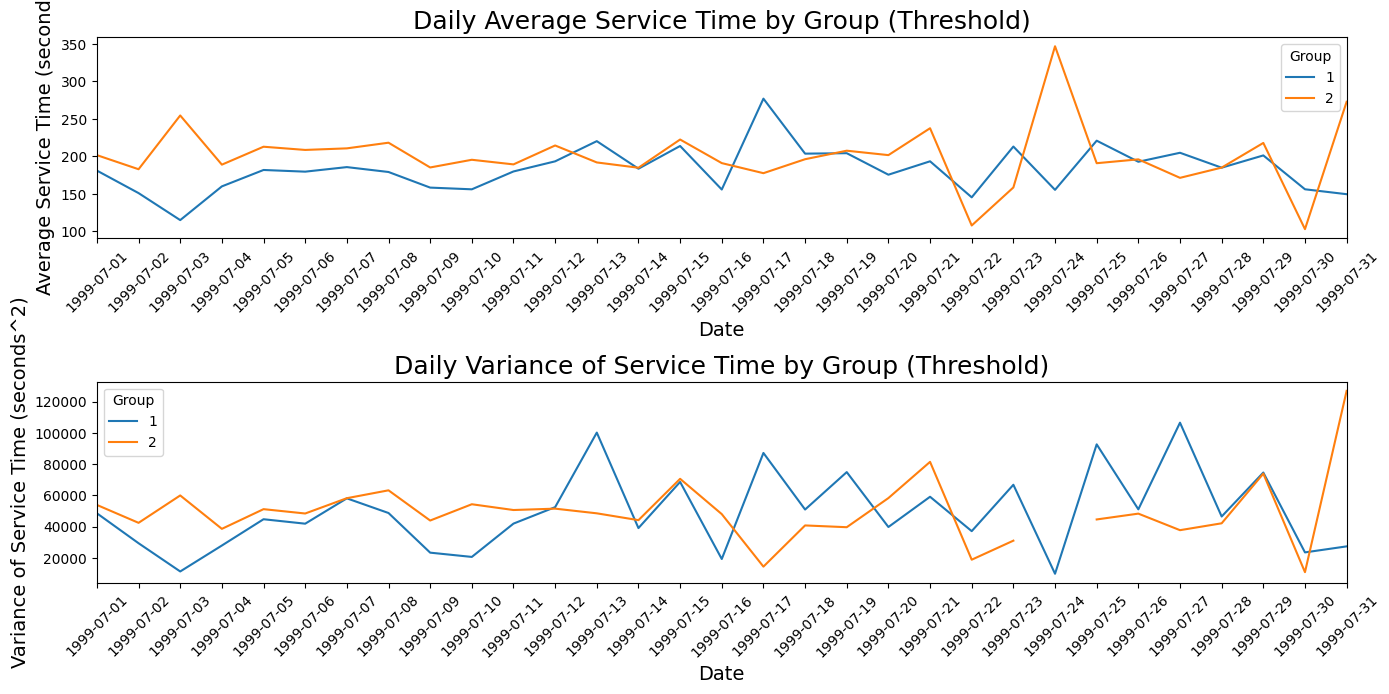

In [231]:
# Plot the average and variance as time series
plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)
ax1 = plt.gca()
mean_pivot.plot(ax=ax1)
plt.title('Daily Average Service Time by Group (Threshold)', fontsize=18)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Average Service Time (seconds)', fontsize=14)
plt.legend(title='Group')
# Force all dates to appear as x-ticks
ax1.set_xticks(mean_pivot.index)
ax1.set_xticklabels([date.strftime('%Y-%m-%d') for date in mean_pivot.index], rotation=45)

plt.subplot(2, 1, 2)
ax2 = plt.gca()
var_pivot.plot(ax=ax2)
plt.title('Daily Variance of Service Time by Group (Threshold)', fontsize=18)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Variance of Service Time (seconds^2)', fontsize=14)
plt.legend(title='Group')
plt.tight_layout()
# Force all dates to appear as x-ticks
ax2.set_xticks(var_pivot.index)
ax2.set_xticklabels([date.strftime('%Y-%m-%d') for date in var_pivot.index], rotation=45)

plt.show()

In [232]:
# Check the calls performed in July 24 by group 2
cc_type_df[(cc_type_df['date'] == '1999-07-24') & (cc_type_df['group'] == '2')].head(20)

,call_id,type,date,vru_entry,vru_exit,vru_time,q_start,q_exit,q_time,outcome,ser_start,ser_exit,ser_time,server,day_of_week,date_str,type_group,group
11791,37548,PS,1999-07-24,1999-07-24 23:56:41,1999-07-24 23:56:47,6,23:56:47,23:57:34,47,AGENT,1999-07-24 23:57:34,1999-07-24 00:03:21,347,DARMON,Saturday,1999-07-24,REGULAR,2


Missing variance of group 2 on July 24th was caused by only one call record on that particular day.

### Let's try performing Ward's clustering

In [233]:
scaler = StandardScaler()
X = scaler.fit_transform(mean_ser_time[['REGULAR', 'SPECIFIC']])

clustering = AgglomerativeClustering(n_clusters=2, linkage='ward')
mean_ser_time['cluster'] = clustering.fit_predict(X)

# Change cluster labels to '1' and '2'
mean_ser_time['cluster'] = mean_ser_time['cluster'].astype(str).replace({'0': '1', '1': '2'})

mean_ser_time

type_group,REGULAR,SPECIFIC,group,cluster
server,,,,
ELI,361.764706,438.482192,1,1
YITZ,236.439901,398.989848,1,1
ZOHARI,240.498322,327.569191,1,1
YIFAT,209.870748,325.383234,1,1
DARMON,275.068966,268.532468,2,1
PINHAS,390.323699,258.890688,2,1
SHLOMO,159.908163,232.100000,1,2
MEIR,194.906667,225.211538,1,2
NAAMA,181.256776,194.736111,1,2


In [234]:
# Check the average service time for each cluster
mean_ser_time.groupby('cluster')[['REGULAR', 'SPECIFIC']].mean()

type_group,REGULAR,SPECIFIC
cluster,,
1,285.661057,336.307937
2,182.737977,167.451601


In [235]:
# Apply the grouping to the main dataframe
cc_type_df['cluster'] = np.where(cc_type_df['server'].isin(mean_ser_time[mean_ser_time['cluster'] == '1'].index), '1', '2')

# Check the number of calls performed by each group
cc_type_df[cc_type_df['cluster'] == '1']['ser_time'].count(), cc_type_df[cc_type_df['cluster'] == '2']['ser_time'].count()

(np.int64(3849), np.int64(23957))

In [236]:
# Calculate daily average and variance for each group
grouped_daily = cc_type_df.groupby(['date', 'cluster'])['ser_time'].agg(['mean', 'var']).reset_index()

mean_pivot = grouped_daily.pivot(index='date', columns='cluster', values='mean')
var_pivot = grouped_daily.pivot(index='date', columns='cluster', values='var')

mean_pivot, var_pivot

(cluster              1           2
 date                              
 1999-07-01  265.550388  173.464286
 1999-07-02  260.500000  168.345534
 1999-07-03  148.192308  176.182796
 1999-07-04  204.435798  163.326709
 1999-07-05  263.278947  180.973443
 1999-07-06  217.694981  187.849151
 1999-07-07  253.546448  188.027411
 1999-07-08  276.527273  183.861773
 1999-07-09  209.651515  171.624685
 1999-07-10  535.500000  157.761905
 1999-07-11  279.054217  171.352273
 1999-07-12  264.368421  189.353612
 1999-07-13  388.301887  175.553172
 1999-07-14  261.058252  177.218888
 1999-07-15  344.061111  191.120853
 1999-07-16         NaN  188.163580
 1999-07-17  277.048780  177.541667
 1999-07-18  341.807692  181.005994
 1999-07-19  269.242009  191.137643
 1999-07-20  298.647619  168.260870
 1999-07-21  377.963855  185.297009
 1999-07-22  198.065476  101.173913
 1999-07-23  345.120000  186.915094
 1999-07-24  187.000000  150.857143
 1999-07-25  360.416058  184.129239
 1999-07-26  319.230088  180

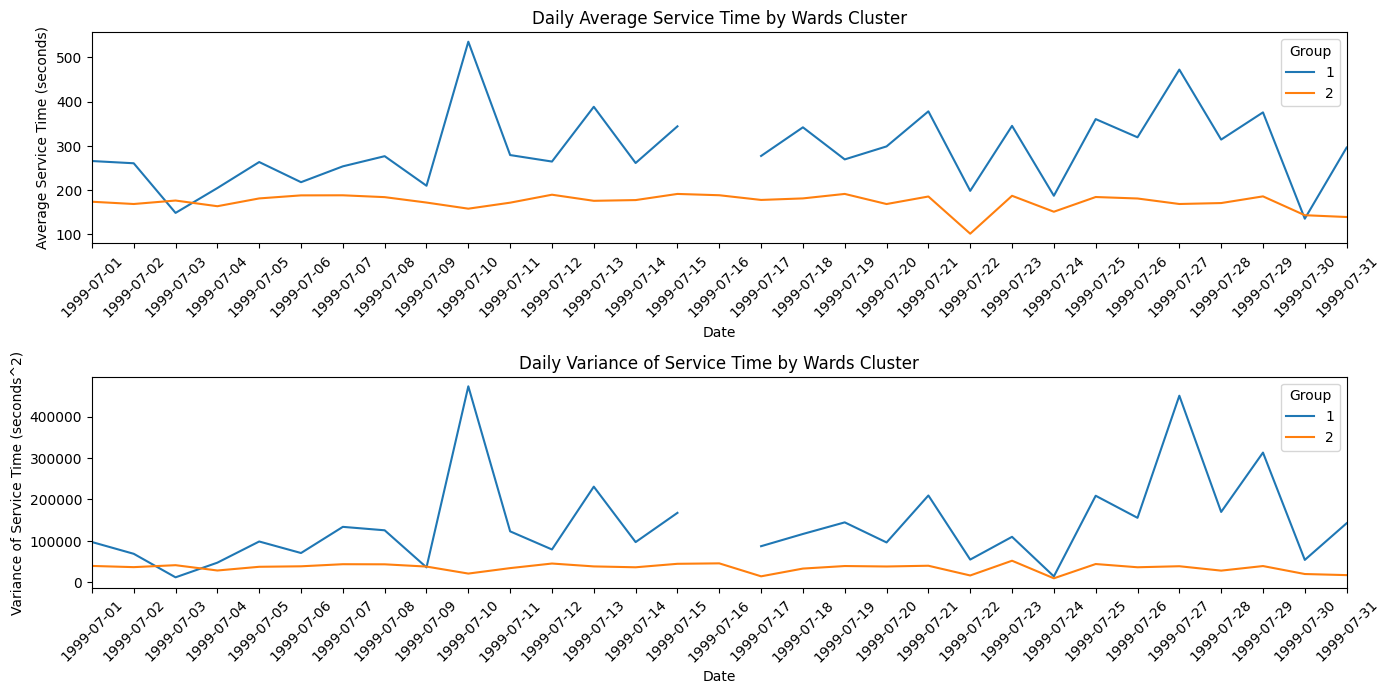

In [237]:
# Plot the average and variance as time series
plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)
ax1 = plt.gca()
mean_pivot.plot(ax=ax1)
plt.title('Daily Average Service Time by Wards Cluster')
plt.xlabel('Date')
plt.ylabel('Average Service Time (seconds)')
plt.legend(title='Group')
# Force all dates to appear as x-ticks
ax1.set_xticks(mean_pivot.index)
ax1.set_xticklabels([date.strftime('%Y-%m-%d') for date in mean_pivot.index], rotation=45)

plt.subplot(2, 1, 2)
ax2 = plt.gca()
var_pivot.plot(ax=ax2)
plt.title('Daily Variance of Service Time by Wards Cluster')
plt.xlabel('Date')
plt.ylabel('Variance of Service Time (seconds^2)')
plt.legend(title='Group')
plt.tight_layout()
# Force all dates to appear as x-ticks
ax2.set_xticks(var_pivot.index)
ax2.set_xticklabels([date.strftime('%Y-%m-%d') for date in var_pivot.index], rotation=45)

plt.show()

One particular date (1999-07-16) had their record missing. This is due to no agent from group 0 was working on that day.

From the ward clustering method we see how the spike in one particular date still happens, this is because of the outlier

In [238]:
# Display mean service time for each grouping (group, cluster)

# Display mean service time for each grouping (group, cluster)
display(mean_ser_time.groupby('group')[['REGULAR', 'SPECIFIC']].mean())
display(mean_ser_time.groupby('cluster')[['REGULAR', 'SPECIFIC']].mean())

type_group,REGULAR,SPECIFIC
group,,
1,196.441097,237.839930
2,219.354470,175.625745


type_group,REGULAR,SPECIFIC
cluster,,
1,285.661057,336.307937
2,182.737977,167.451601


### Let's finalise and decide to use group to proceed

In [239]:
# Finalise dataframe, exclude the group and cluster columns

cc_final_df = cc_type_df.copy()
cc_final_df = cc_final_df.drop(columns=['cluster'])

cc_final_df.head()

,call_id,type,date,vru_entry,vru_exit,vru_time,q_start,q_exit,q_time,outcome,ser_start,ser_exit,ser_time,server,day_of_week,date_str,type_group,group
2,41888,PS,1999-07-01,1999-07-01 07:30:27,1999-07-01 07:30:35,8,0:00:00,0:00:00,0,AGENT,1999-07-01 07:30:35,1999-07-01 07:34:16,221,MORIAH,Thursday,1999-07-01,REGULAR,2
3,41889,PS,1999-07-01,1999-07-01 07:49:32,1999-07-01 07:49:37,5,7:49:37,7:50:27,50,AGENT,1999-07-01 07:50:26,1999-07-01 07:51:48,82,ANAT,Thursday,1999-07-01,REGULAR,2
4,41890,PS,1999-07-01,1999-07-01 08:03:56,1999-07-01 08:04:08,12,0:00:00,0:00:00,0,AGENT,1999-07-01 08:04:07,1999-07-01 08:05:25,78,KAZAV,Thursday,1999-07-01,REGULAR,1
5,41891,PS,1999-07-01,1999-07-01 08:22:12,1999-07-01 08:22:25,13,0:00:00,0:00:00,0,AGENT,1999-07-01 08:22:24,1999-07-01 08:32:12,588,YIFAT,Thursday,1999-07-01,REGULAR,1
6,41892,PS,1999-07-01,1999-07-01 08:32:24,1999-07-01 08:32:29,5,8:32:29,8:32:45,16,AGENT,1999-07-01 08:32:44,1999-07-01 08:33:39,55,TOVA,Thursday,1999-07-01,REGULAR,1


### Let's calculate the interarrival times

In [240]:
# Split dataframe to simple and complex calls df

cc_simple_df = cc_final_df[cc_final_df['type_group'] == 'REGULAR'].copy()
cc_complex_df = cc_final_df[cc_final_df['type_group'] == 'SPECIFIC'].copy()

cc_simple_df = cc_simple_df.sort_values(by='vru_entry')
cc_complex_df = cc_complex_df.sort_values(by='vru_entry')

# Calculate interarrival times
cc_simple_df['interarrival_time'] = (
    cc_simple_df.groupby('date')['vru_entry'].diff().dt.total_seconds()
    )
cc_complex_df['interarrival_time'] = (
    cc_complex_df.groupby('date')['vru_entry'].diff().dt.total_seconds()
    )

# Move columns near vru_entry
cc_simple_df = cc_simple_df[['call_id', 'type', 'date', 'vru_entry', 'interarrival_time'] + [col for col in cc_simple_df.columns if col not in ['call_id', 'type', 'date', 'vru_entry', 'interarrival_time']]]
cc_complex_df = cc_complex_df[['call_id', 'type', 'date', 'vru_entry', 'interarrival_time'] + [col for col in cc_complex_df.columns if col not in ['call_id', 'type', 'date', 'vru_entry', 'interarrival_time']]]

cc_simple_df['interarrival_time'].count(), cc_complex_df['interarrival_time'].count(), \
    cc_simple_df.head(), cc_complex_df.head()

(np.int64(20466),
 np.int64(7278),
        call_id type       date           vru_entry  interarrival_time  \
 9246     36802   PS 1999-07-01 1999-07-01 07:02:02                NaN   
 5771     42243   PS 1999-07-01 1999-07-01 07:07:42              340.0   
 12589    11120   PS 1999-07-01 1999-07-01 07:07:55               13.0   
 13751    20926   PS 1999-07-01 1999-07-01 07:08:22               27.0   
 33996    23067   PS 1999-07-01 1999-07-01 07:09:11               49.0   
 
                  vru_exit  vru_time  q_start   q_exit  q_time outcome  \
 9246  1999-07-01 07:02:11         9  0:00:00  0:00:00       0   AGENT   
 5771  1999-07-01 07:07:52        10  0:00:00  0:00:00       0   AGENT   
 12589 1999-07-01 07:08:09        14  0:00:00  0:00:00       0   AGENT   
 13751 1999-07-01 07:08:30         8  0:00:00  0:00:00       0   AGENT   
 33996 1999-07-01 07:09:17         6  7:09:17  7:10:04      47   AGENT   
 
                 ser_start            ser_exit  ser_time  server day_of_w

In [241]:
cc_simple_df['interarrival_time'].describe(), cc_complex_df['interarrival_time'].describe()

(count    20466.000000
 mean        70.780221
 std         98.688575
 min          0.000000
 25%         19.000000
 50%         45.000000
 75%         92.000000
 max       5610.000000
 Name: interarrival_time, dtype: float64,
 count    7278.000000
 mean      192.277961
 std       259.762028
 min         0.000000
 25%        46.000000
 50%       114.000000
 75%       242.000000
 max      4602.000000
 Name: interarrival_time, dtype: float64)

In [242]:
# Check top 10 largest interarrival times
cc_simple_df.nlargest(10, 'interarrival_time')

,call_id,type,date,vru_entry,interarrival_time,vru_exit,vru_time,q_start,q_exit,q_time,outcome,ser_start,ser_exit,ser_time,server,day_of_week,date_str,type_group,group
5486,30819,PS,1999-07-22,1999-07-22 09:50:25,5610.0,1999-07-22 09:50:31,6,9:50:31,9:50:49,18,AGENT,1999-07-22 09:50:48,1999-07-22 09:53:55,187,ROTH,Thursday,1999-07-22,REGULAR,2
10431,38005,PS,1999-07-25,1999-07-25 22:23:15,4636.0,1999-07-25 22:23:30,15,0:00:00,0:00:00,0,AGENT,1999-07-25 22:23:29,1999-07-25 22:31:11,462,DARMON,Sunday,1999-07-25,REGULAR,2
21746,43124,PS,1999-07-22,1999-07-22 08:04:15,2188.0,1999-07-22 08:04:26,11,8:04:26,8:04:35,9,AGENT,1999-07-22 08:04:34,1999-07-22 08:05:08,34,AVI,Thursday,1999-07-22,REGULAR,1
10929,36664,PS,1999-07-05,1999-07-05 18:37:37,2143.0,1999-07-05 18:37:47,10,18:37:47,18:38:07,20,AGENT,1999-07-05 18:38:06,1999-07-05 18:38:13,7,AVI,Monday,1999-07-05,REGULAR,1
881,42782,PS,1999-07-15,1999-07-15 18:53:01,1671.0,1999-07-15 18:53:15,14,0:00:00,0:00:00,0,AGENT,1999-07-15 18:53:14,1999-07-15 19:01:28,494,AVNI,Thursday,1999-07-15,REGULAR,2
864,42765,PS,1999-07-15,1999-07-15 16:26:34,1444.0,1999-07-15 16:27:00,26,0:00:00,0:00:00,0,AGENT,1999-07-15 16:26:59,1999-07-15 16:28:10,71,AVNI,Thursday,1999-07-15,REGULAR,2
34944,24032,PS,1999-07-27,1999-07-27 19:48:41,1295.0,1999-07-27 19:48:47,6,19:48:47,19:49:25,38,AGENT,1999-07-27 19:49:24,1999-07-27 19:50:52,88,BENSION,Tuesday,1999-07-27,REGULAR,2
948,42850,PS,1999-07-17,1999-07-17 23:33:06,1165.0,1999-07-17 23:33:17,11,0:00:00,0:00:00,0,AGENT,1999-07-17 23:33:17,1999-07-17 23:39:32,375,YITZ,Saturday,1999-07-17,REGULAR,1
2428,38395,PS,1999-07-18,1999-07-18 10:32:32,1160.0,1999-07-18 10:32:43,11,0:00:00,0:00:00,0,AGENT,1999-07-18 10:32:41,1999-07-18 10:33:12,31,AVI,Sunday,1999-07-18,REGULAR,1
21767,43145,PS,1999-07-22,1999-07-22 14:36:08,1010.0,1999-07-22 14:36:14,6,14:36:14,14:36:37,23,AGENT,1999-07-22 14:36:35,1999-07-22 14:39:09,154,VICKY,Thursday,1999-07-22,REGULAR,2


In [243]:
cc_complex_df.nlargest(10, 'interarrival_time')

,call_id,type,date,vru_entry,interarrival_time,vru_exit,vru_time,q_start,q_exit,q_time,outcome,ser_start,ser_exit,ser_time,server,day_of_week,date_str,type_group,group
11500,37249,NE,1999-07-15,1999-07-15 21:09:30,4602.0,1999-07-15 21:09:52,22,0:00:00,0:00:00,0,AGENT,1999-07-15 21:09:50,1999-07-15 21:12:28,158,AVI,Thursday,1999-07-15,SPECIFIC,1
16035,42664,NW,1999-07-22,1999-07-22 15:08:48,4071.0,1999-07-22 15:09:03,15,0:00:00,0:00:00,0,AGENT,1999-07-22 15:09:02,1999-07-22 15:09:44,42,VICKY,Thursday,1999-07-22,SPECIFIC,2
38459,7335,IN,1999-07-15,1999-07-15 08:02:53,3751.0,1999-07-15 08:03:06,13,0:00:00,0:00:00,0,AGENT,1999-07-15 08:03:04,1999-07-15 08:28:42,1538,YIFAT,Thursday,1999-07-15,SPECIFIC,1
30713,43517,NW,1999-07-18,1999-07-18 23:48:43,3338.0,1999-07-18 23:49:00,17,0:00:00,0:00:00,0,AGENT,1999-07-18 23:48:59,1999-07-18 23:49:42,43,BENSION,Sunday,1999-07-18,SPECIFIC,2
15374,6343,IN,1999-07-18,1999-07-18 22:21:47,3040.0,1999-07-18 22:22:06,19,0:00:00,0:00:00,0,AGENT,1999-07-18 22:22:05,1999-07-18 22:24:18,133,BENSION,Sunday,1999-07-18,SPECIFIC,2
8119,43930,NW,1999-07-16,1999-07-16 13:12:32,2652.0,1999-07-16 13:12:45,13,0:00:00,0:00:00,0,AGENT,1999-07-16 13:12:44,1999-07-16 13:14:03,79,STEREN,Friday,1999-07-16,SPECIFIC,2
37117,21939,NW,1999-07-13,1999-07-13 23:04:53,2628.0,1999-07-13 23:05:03,10,23:05:03,23:05:49,46,AGENT,1999-07-13 23:05:48,1999-07-13 23:12:51,423,PINHAS,Tuesday,1999-07-13,SPECIFIC,2
25586,46692,NW,1999-07-19,1999-07-19 23:00:51,2626.0,1999-07-19 23:01:00,9,23:01:00,23:08:38,458,AGENT,1999-07-19 23:08:37,1999-07-19 23:16:54,497,PINHAS,Monday,1999-07-19,SPECIFIC,2
20162,44411,NW,1999-07-21,1999-07-21 20:38:48,2554.0,1999-07-21 20:39:02,14,0:00:00,0:00:00,0,AGENT,1999-07-21 20:39:02,1999-07-21 20:41:06,124,MEIR,Wednesday,1999-07-21,SPECIFIC,1
38679,7555,IN,1999-07-23,1999-07-23 14:28:27,2440.0,1999-07-23 14:28:36,9,14:28:36,14:31:56,200,AGENT,1999-07-23 14:31:55,1999-07-23 14:34:06,131,DORIT,Friday,1999-07-23,SPECIFIC,1


### I guess its normal, given how small the complex call samples.

In [244]:
# Check the 0 values in interarrival times
cc_simple_df[cc_simple_df['interarrival_time'] == 0]['interarrival_time'].count(), cc_complex_df[cc_complex_df['interarrival_time'] == 0]['interarrival_time'].count() 

(np.int64(139), np.int64(14))

In [245]:
cc_simple_df[cc_simple_df['interarrival_time'] == 0].head(10)

,call_id,type,date,vru_entry,interarrival_time,vru_exit,vru_time,q_start,q_exit,q_time,outcome,ser_start,ser_exit,ser_time,server,day_of_week,date_str,type_group,group
10652,36384,PS,1999-07-01,1999-07-01 08:28:51,0.0,1999-07-01 08:28:56,5,8:28:56,8:30:59,123,AGENT,1999-07-01 08:30:58,1999-07-01 08:32:39,101,TOVA,Thursday,1999-07-01,REGULAR,1
29092,41870,PS,1999-07-01,1999-07-01 09:56:22,0.0,1999-07-01 09:56:28,6,9:56:28,9:57:33,65,AGENT,1999-07-01 09:57:32,1999-07-01 09:58:18,46,TOVA,Thursday,1999-07-01,REGULAR,1
10663,36395,PS,1999-07-01,1999-07-01 11:46:13,0.0,1999-07-01 11:46:20,7,11:46:20,11:49:35,195,AGENT,1999-07-01 11:49:33,1999-07-01 11:50:39,66,SHARON,Thursday,1999-07-01,REGULAR,1
5788,42260,PS,1999-07-01,1999-07-01 11:57:15,0.0,1999-07-01 11:57:20,5,11:57:20,11:59:27,127,AGENT,1999-07-01 11:59:26,1999-07-01 12:01:20,114,ANAT,Thursday,1999-07-01,REGULAR,2
4362,29665,PS,1999-07-01,1999-07-01 12:01:37,0.0,1999-07-01 12:01:43,6,12:01:43,12:03:44,121,AGENT,1999-07-01 12:03:44,1999-07-01 12:04:06,22,SHARON,Thursday,1999-07-01,REGULAR,1
20741,42106,PS,1999-07-01,1999-07-01 12:20:59,0.0,1999-07-01 12:21:04,5,12:21:04,12:21:09,5,AGENT,1999-07-01 12:21:08,1999-07-01 12:26:05,297,SHARON,Thursday,1999-07-01,REGULAR,1
23939,45017,PS,1999-07-01,1999-07-01 12:28:54,0.0,1999-07-01 12:29:00,6,12:29:00,12:29:51,51,AGENT,1999-07-01 12:29:50,1999-07-01 12:30:21,31,KAZAV,Thursday,1999-07-01,REGULAR,1
20754,42119,PS,1999-07-01,1999-07-01 14:20:06,0.0,1999-07-01 14:20:12,6,14:20:12,14:21:49,97,AGENT,1999-07-01 14:21:48,1999-07-01 14:24:33,165,BASCH,Thursday,1999-07-01,REGULAR,2
16627,43317,PS,1999-07-01,1999-07-01 15:57:23,0.0,1999-07-01 15:57:29,6,15:57:29,15:57:40,11,AGENT,1999-07-01 15:57:39,1999-07-01 16:00:19,160,ROTH,Thursday,1999-07-01,REGULAR,2
13792,20968,PS,1999-07-01,1999-07-01 17:24:01,0.0,1999-07-01 17:24:08,7,17:24:08,17:24:47,39,AGENT,1999-07-01 17:24:46,1999-07-01 17:26:41,115,AVI,Thursday,1999-07-01,REGULAR,1


In [246]:
cc_complex_df[cc_complex_df['interarrival_time'] == 0].head(10)

,call_id,type,date,vru_entry,interarrival_time,vru_exit,vru_time,q_start,q_exit,q_time,outcome,ser_start,ser_exit,ser_time,server,day_of_week,date_str,type_group,group
35194,22126,NE,1999-07-01,1999-07-01 10:18:22,0.0,1999-07-01 10:18:32,10,0:00:00,0:00:00,0,AGENT,1999-07-01 10:18:31,1999-07-01 10:23:41,310,ELI,Thursday,1999-07-01,SPECIFIC,1
1605,37553,NE,1999-07-04,1999-07-04 10:01:55,0.0,1999-07-04 10:02:00,5,10:02:00,10:03:42,102,AGENT,1999-07-04 10:03:40,1999-07-04 10:04:17,37,VICKY,Sunday,1999-07-04,SPECIFIC,2
193,42082,NE,1999-07-04,1999-07-04 16:52:27,0.0,1999-07-04 16:52:39,12,0:00:00,0:00:00,0,AGENT,1999-07-04 16:52:38,1999-07-04 17:15:54,1396,ELI,Sunday,1999-07-04,SPECIFIC,1
9447,37006,NW,1999-07-04,1999-07-04 19:23:15,0.0,1999-07-04 19:23:25,10,19:23:25,19:27:06,221,AGENT,1999-07-04 19:27:05,1999-07-04 19:28:49,104,GILI,Sunday,1999-07-04,SPECIFIC,1
9753,37318,NW,1999-07-08,1999-07-08 12:24:07,0.0,1999-07-08 12:24:17,10,12:24:17,12:29:49,332,AGENT,1999-07-08 12:29:48,1999-07-08 12:30:18,30,SHARON,Thursday,1999-07-08,SPECIFIC,1
30230,43022,NW,1999-07-11,1999-07-11 10:46:49,0.0,1999-07-11 10:46:58,9,10:46:58,10:55:52,534,AGENT,1999-07-11 10:55:51,1999-07-11 10:56:23,32,AVI,Sunday,1999-07-11,SPECIFIC,1
21392,42764,NE,1999-07-15,1999-07-15 10:53:43,0.0,1999-07-15 10:53:48,5,10:53:48,10:55:00,72,AGENT,1999-07-15 10:54:59,1999-07-15 10:57:18,139,BASCH,Thursday,1999-07-15,SPECIFIC,2
987,42889,NE,1999-07-18,1999-07-18 11:38:57,0.0,1999-07-18 11:39:02,5,11:39:02,11:39:51,49,AGENT,1999-07-18 11:39:51,1999-07-18 11:56:50,1019,ELI,Sunday,1999-07-18,SPECIFIC,1
6892,43381,NE,1999-07-21,1999-07-21 09:57:24,0.0,1999-07-21 09:57:30,6,9:57:30,9:59:14,104,AGENT,1999-07-21 09:59:13,1999-07-21 10:00:01,48,TOVA,Wednesday,1999-07-21,SPECIFIC,1
38601,7477,IN,1999-07-21,1999-07-21 13:10:46,0.0,1999-07-21 13:10:55,9,13:10:55,13:16:40,345,AGENT,1999-07-21 13:16:39,1999-07-21 13:21:08,269,YITZ,Wednesday,1999-07-21,SPECIFIC,1


In [247]:
# Check several records with same vru_entry time
dupe_times = cc_simple_df[cc_simple_df['interarrival_time'] == 0]['vru_entry'].unique()

cc_simple_df[cc_simple_df['vru_entry'].isin(dupe_times)].sort_values(by='vru_entry').head(20)

,call_id,type,date,vru_entry,interarrival_time,vru_exit,vru_time,q_start,q_exit,q_time,outcome,ser_start,ser_exit,ser_time,server,day_of_week,date_str,type_group,group
27456,5691,PS,1999-07-01,1999-07-01 08:28:51,110.0,1999-07-01 08:28:56,5,8:28:56,8:30:25,89,AGENT,1999-07-01 08:30:25,1999-07-01 08:33:26,181,KAZAV,Thursday,1999-07-01,REGULAR,1
10652,36384,PS,1999-07-01,1999-07-01 08:28:51,0.0,1999-07-01 08:28:56,5,8:28:56,8:30:59,123,AGENT,1999-07-01 08:30:58,1999-07-01 08:32:39,101,TOVA,Thursday,1999-07-01,REGULAR,1
19023,43248,PS,1999-07-01,1999-07-01 09:56:22,30.0,1999-07-01 09:56:28,6,9:56:28,9:56:46,18,AGENT,1999-07-01 09:56:46,1999-07-01 10:03:04,378,SHARON,Thursday,1999-07-01,REGULAR,1
29092,41870,PS,1999-07-01,1999-07-01 09:56:22,0.0,1999-07-01 09:56:28,6,9:56:28,9:57:33,65,AGENT,1999-07-01 09:57:32,1999-07-01 09:58:18,46,TOVA,Thursday,1999-07-01,REGULAR,1
7227,43024,PS,1999-07-01,1999-07-01 11:46:13,16.0,1999-07-01 11:46:19,6,11:46:19,11:48:34,135,AGENT,1999-07-01 11:48:34,1999-07-01 11:55:29,415,BASCH,Thursday,1999-07-01,REGULAR,2
10663,36395,PS,1999-07-01,1999-07-01 11:46:13,0.0,1999-07-01 11:46:20,7,11:46:20,11:49:35,195,AGENT,1999-07-01 11:49:33,1999-07-01 11:50:39,66,SHARON,Thursday,1999-07-01,REGULAR,1
2926,33038,PS,1999-07-01,1999-07-01 11:57:15,6.0,1999-07-01 11:57:21,6,11:57:21,12:01:05,224,AGENT,1999-07-01 12:01:04,1999-07-01 12:03:32,148,KAZAV,Thursday,1999-07-01,REGULAR,1
5788,42260,PS,1999-07-01,1999-07-01 11:57:15,0.0,1999-07-01 11:57:20,5,11:57:20,11:59:27,127,AGENT,1999-07-01 11:59:26,1999-07-01 12:01:20,114,ANAT,Thursday,1999-07-01,REGULAR,2
16590,43280,PS,1999-07-01,1999-07-01 12:01:37,161.0,1999-07-01 12:01:43,6,12:01:43,12:02:24,41,AGENT,1999-07-01 12:02:23,1999-07-01 12:12:23,600,BASCH,Thursday,1999-07-01,REGULAR,2
4362,29665,PS,1999-07-01,1999-07-01 12:01:37,0.0,1999-07-01 12:01:43,6,12:01:43,12:03:44,121,AGENT,1999-07-01 12:03:44,1999-07-01 12:04:06,22,SHARON,Thursday,1999-07-01,REGULAR,1


In [248]:
# Check several records with same vru_entry time
dupe_times = cc_complex_df[cc_complex_df['interarrival_time'] == 0]['vru_entry'].unique()

cc_complex_df[cc_complex_df['vru_entry'].isin(dupe_times)].sort_values(by='vru_entry').head(20)

,call_id,type,date,vru_entry,interarrival_time,vru_exit,vru_time,q_start,q_exit,q_time,outcome,ser_start,ser_exit,ser_time,server,day_of_week,date_str,type_group,group
27474,5709,NW,1999-07-01,1999-07-01 10:18:22,44.0,1999-07-01 10:18:31,9,10:18:31,10:21:19,168,AGENT,1999-07-01 10:21:18,1999-07-01 10:23:06,108,KAZAV,Thursday,1999-07-01,SPECIFIC,1
35194,22126,NE,1999-07-01,1999-07-01 10:18:22,0.0,1999-07-01 10:18:32,10,0:00:00,0:00:00,0,AGENT,1999-07-01 10:18:31,1999-07-01 10:23:41,310,ELI,Thursday,1999-07-01,SPECIFIC,1
12732,11267,NW,1999-07-04,1999-07-04 10:01:55,13.0,1999-07-04 10:02:04,9,10:02:04,10:05:50,226,AGENT,1999-07-04 10:05:49,1999-07-04 10:06:59,70,AVI,Sunday,1999-07-04,SPECIFIC,1
1605,37553,NE,1999-07-04,1999-07-04 10:01:55,0.0,1999-07-04 10:02:00,5,10:02:00,10:03:42,102,AGENT,1999-07-04 10:03:40,1999-07-04 10:04:17,37,VICKY,Sunday,1999-07-04,SPECIFIC,2
12377,3479,TT,1999-07-04,1999-07-04 16:52:27,77.0,1999-07-04 16:52:27,0,16:52:27,16:52:58,31,AGENT,1999-07-04 16:52:57,1999-07-04 16:53:09,12,AVNI,Sunday,1999-07-04,SPECIFIC,2
193,42082,NE,1999-07-04,1999-07-04 16:52:27,0.0,1999-07-04 16:52:39,12,0:00:00,0:00:00,0,AGENT,1999-07-04 16:52:38,1999-07-04 17:15:54,1396,ELI,Sunday,1999-07-04,SPECIFIC,1
9000,3222,TT,1999-07-04,1999-07-04 19:23:15,44.0,1999-07-04 19:23:16,1,0:00:00,0:00:00,0,AGENT,1999-07-04 19:23:16,1999-07-04 19:23:31,15,GELBER,Sunday,1999-07-04,SPECIFIC,2
9447,37006,NW,1999-07-04,1999-07-04 19:23:15,0.0,1999-07-04 19:23:25,10,19:23:25,19:27:06,221,AGENT,1999-07-04 19:27:05,1999-07-04 19:28:49,104,GILI,Sunday,1999-07-04,SPECIFIC,1
6304,42782,NW,1999-07-08,1999-07-08 12:24:07,9.0,1999-07-08 12:24:16,9,12:24:16,12:28:31,255,AGENT,1999-07-08 12:28:30,1999-07-08 12:29:43,73,SHARON,Thursday,1999-07-08,SPECIFIC,1
9753,37318,NW,1999-07-08,1999-07-08 12:24:07,0.0,1999-07-08 12:24:17,10,12:24:17,12:29:49,332,AGENT,1999-07-08 12:29:48,1999-07-08 12:30:18,30,SHARON,Thursday,1999-07-08,SPECIFIC,1


As we can see the records with same `vru_time` have different values in other columns, so these records are valid.

Because in the real world data, interarrival times do not follow the Poisson process assumption, this is fine and we can proceed

In [249]:
# Combine the two dataframes back into one
cc_final_df = pd.concat([cc_simple_df, cc_complex_df], ignore_index=True)

cc_final_df.head()

,call_id,type,date,vru_entry,interarrival_time,vru_exit,vru_time,q_start,q_exit,q_time,outcome,ser_start,ser_exit,ser_time,server,day_of_week,date_str,type_group,group
0,36802,PS,1999-07-01,1999-07-01 07:02:02,NaN,1999-07-01 07:02:11,9,0:00:00,0:00:00,0,AGENT,1999-07-01 07:02:11,1999-07-01 07:02:22,11,TOVA,Thursday,1999-07-01,REGULAR,1
1,42243,PS,1999-07-01,1999-07-01 07:07:42,340.0,1999-07-01 07:07:52,10,0:00:00,0:00:00,0,AGENT,1999-07-01 07:07:51,1999-07-01 07:12:31,280,TOVA,Thursday,1999-07-01,REGULAR,1
2,11120,PS,1999-07-01,1999-07-01 07:07:55,13.0,1999-07-01 07:08:09,14,0:00:00,0:00:00,0,AGENT,1999-07-01 07:08:08,1999-07-01 07:11:42,214,ANAT,Thursday,1999-07-01,REGULAR,2
3,20926,PS,1999-07-01,1999-07-01 07:08:22,27.0,1999-07-01 07:08:30,8,0:00:00,0:00:00,0,AGENT,1999-07-01 07:08:29,1999-07-01 07:09:56,87,MORIAH,Thursday,1999-07-01,REGULAR,2
4,23067,PS,1999-07-01,1999-07-01 07:09:11,49.0,1999-07-01 07:09:17,6,7:09:17,7:10:04,47,AGENT,1999-07-01 07:10:03,1999-07-01 07:11:24,81,MORIAH,Thursday,1999-07-01,REGULAR,2


In [250]:
cc_final_df[(cc_final_df['group'] == '1') & (cc_final_df['type_group'] == 'REGULAR')]

,call_id,type,date,vru_entry,interarrival_time,vru_exit,vru_time,q_start,q_exit,q_time,outcome,ser_start,ser_exit,ser_time,server,day_of_week,date_str,type_group,group
0,36802,PS,1999-07-01,1999-07-01 07:02:02,NaN,1999-07-01 07:02:11,9,0:00:00,0:00:00,0,AGENT,1999-07-01 07:02:11,1999-07-01 07:02:22,11,TOVA,Thursday,1999-07-01,REGULAR,1
1,42243,PS,1999-07-01,1999-07-01 07:07:42,340.0,1999-07-01 07:07:52,10,0:00:00,0:00:00,0,AGENT,1999-07-01 07:07:51,1999-07-01 07:12:31,280,TOVA,Thursday,1999-07-01,REGULAR,1
8,36380,PS,1999-07-01,1999-07-01 07:18:23,199.0,1999-07-01 07:18:33,10,0:00:00,0:00:00,0,AGENT,1999-07-01 07:18:32,1999-07-01 07:20:23,111,TOVA,Thursday,1999-07-01,REGULAR,1
11,22098,PS,1999-07-01,1999-07-01 07:22:50,129.0,1999-07-01 07:23:01,11,0:00:00,0:00:00,0,AGENT,1999-07-01 07:23:01,1999-07-01 07:23:52,51,TOVA,Thursday,1999-07-01,REGULAR,1
13,42060,PS,1999-07-01,1999-07-01 07:26:57,219.0,1999-07-01 07:27:10,13,0:00:00,0:00:00,0,AGENT,1999-07-01 07:27:09,1999-07-01 07:30:27,198,TOVA,Thursday,1999-07-01,REGULAR,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20490,43365,PS,1999-07-31,1999-07-31 23:31:06,17.0,1999-07-31 23:31:12,6,23:31:12,23:32:21,69,AGENT,1999-07-31 23:32:20,1999-07-31 23:32:38,18,ZOHARI,Saturday,1999-07-31,REGULAR,1
20491,44356,PS,1999-07-31,1999-07-31 23:31:46,40.0,1999-07-31 23:31:51,5,23:31:51,23:32:37,46,AGENT,1999-07-31 23:32:36,1999-07-31 23:35:59,203,AVI,Saturday,1999-07-31,REGULAR,1
20493,7002,PS,1999-07-31,1999-07-31 23:37:34,80.0,1999-07-31 23:37:44,10,0:00:00,0:00:00,0,AGENT,1999-07-31 23:37:43,1999-07-31 23:38:05,22,AVI,Saturday,1999-07-31,REGULAR,1
20494,31108,PS,1999-07-31,1999-07-31 23:48:57,683.0,1999-07-31 23:49:07,10,0:00:00,0:00:00,0,AGENT,1999-07-31 23:49:07,1999-07-31 23:51:38,151,AVI,Saturday,1999-07-31,REGULAR,1


In [251]:
cc_final_df[(cc_final_df['group'] == '1') & (cc_final_df['type_group'] == 'REGULAR')]['ser_time']

0         11
1        280
8        111
11        51
13       198
        ... 
20490     18
20491    203
20493     22
20494    151
20496    123
Name: ser_time, Length: 10245, dtype: int64

In [252]:
cc_final_df[(cc_final_df['group'] == '2') & (cc_final_df['type_group'] == 'REGULAR')]['ser_time'].mean()

np.float64(206.03472493172063)

In [253]:
cc_final_df[(cc_final_df['type_group'] == 'REGULAR')]['interarrival_time']

0          NaN
1        340.0
2         13.0
3         27.0
4         49.0
         ...  
20492    268.0
20493     80.0
20494    683.0
20495    432.0
20496     25.0
Name: interarrival_time, Length: 20497, dtype: float64

In [254]:
cc_final_df[(cc_final_df['type_group'] == 'SPECIFIC')]['interarrival_time'].mean()

np.float64(192.27796097829074)

### Finally, perform KS test to get all our parameters

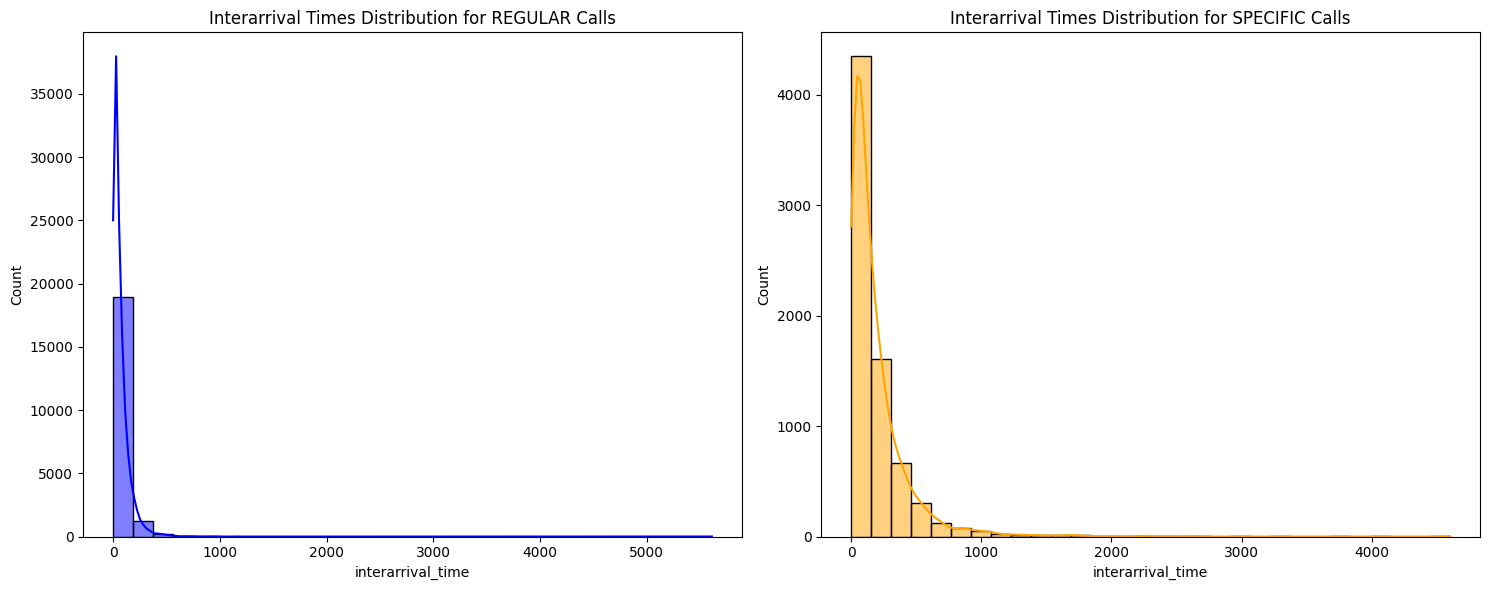

In [255]:
# Plot interarrival times distribution for both call types
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
sns.histplot(cc_simple_df['interarrival_time'], bins=30, kde=True, ax=axes[0], color='blue')
axes[0].set_title('Interarrival Times Distribution for REGULAR Calls')
sns.histplot(cc_complex_df['interarrival_time'], bins=30, kde=True, ax=axes[1], color='orange')
axes[1].set_title('Interarrival Times Distribution for SPECIFIC Calls')
plt.tight_layout()
plt.show()

In [256]:
# Remove NA values in interarrival times
cc_simple_nona_df = cc_simple_df.dropna(subset=['interarrival_time'])
cc_complex_nona_df = cc_complex_df.dropna(subset=['interarrival_time'])

# KS on interarrival times
result_simple = ks_test_distributions_df(cc_simple_nona_df['interarrival_time'])
result_complex = ks_test_distributions_df(cc_complex_nona_df['interarrival_time'])

print("Simple Calls Interarrival Times Distribution Test Results:")
print(result_simple)
print("\nComplex Calls Interarrival Times Distribution Test Results:")
print(result_complex)

c:\Users\irfan\Box\1 - Research Project\Code\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:6921: RuntimeWarning: overflow encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
c:\Users\irfan\Box\1 - Research Project\Code\.venv\Lib\site-packages\numpy\_core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\irfan\Box\1 - Research Project\Code\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:6921: RuntimeWarning: divide by zero encountered in log
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)


Simple Calls Interarrival Times Distribution Test Results:
             D-statistic  p-value  reject_null     best_fit
exponential     0.657383      0.0         True  exponential
gamma           0.991498      0.0         True  exponential
lognormal       0.502445      0.0         True  exponential
weibull         0.528925      0.0         True  exponential

Complex Calls Interarrival Times Distribution Test Results:
             D-statistic       p-value  reject_null   best_fit
exponential     0.674773  0.000000e+00         True  lognormal
gamma           0.986310  0.000000e+00         True  lognormal
lognormal       0.032594  3.752563e-07         True  lognormal
weibull         0.118170  5.219777e-89         True  lognormal


Surely 0 values resulted in zero division or log(0) error.

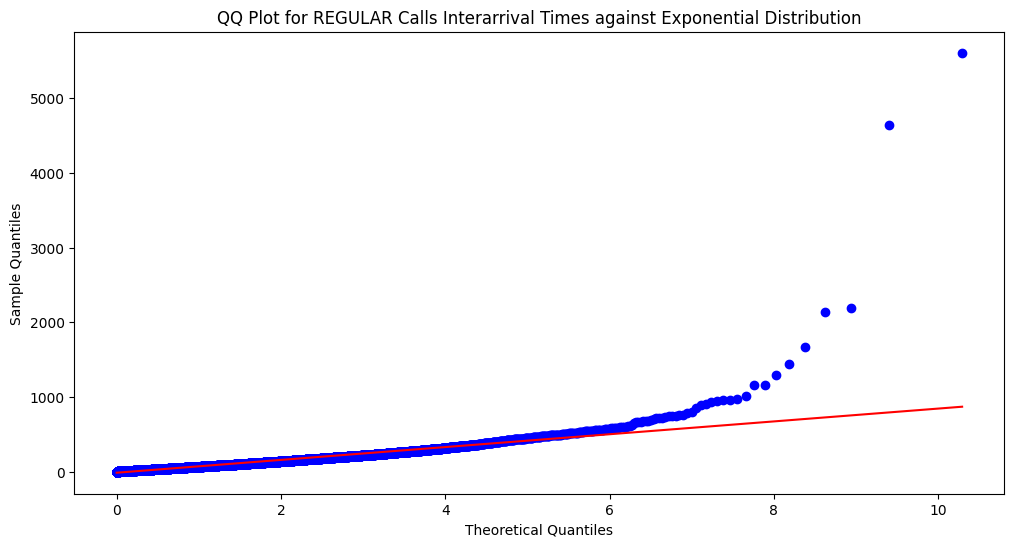

In [257]:
# QQ plots for interarrival times
plt.figure(figsize=(12, 6))
qq_plot_exp(cc_simple_nona_df['interarrival_time'], 'QQ Plot for REGULAR Calls Interarrival Times against Exponential Distribution')
plt.show()

In [258]:
# Check if we remove 0 interarrival times
cc_simple_df_nozero = cc_simple_nona_df[cc_simple_nona_df['interarrival_time'] > 0]
cc_complex_df_nozero = cc_complex_nona_df[cc_complex_nona_df['interarrival_time'] > 0]

# KS on interarrival times without 0 values
result_simple_nozero = ks_test_distributions_df(cc_simple_df_nozero['interarrival_time'])
result_complex_nozero = ks_test_distributions_df(cc_complex_df_nozero['interarrival_time'])

print("Simple Calls Interarrival Times Distribution Test Results (without 0 values):")
print(result_simple_nozero)
print("\nComplex Calls Interarrival Times Distribution Test Results (without 0 values):")
print(result_complex_nozero)

Simple Calls Interarrival Times Distribution Test Results (without 0 values):
             D-statistic       p-value  reject_null   best_fit
exponential     0.659271  0.000000e+00         True  lognormal
gamma           0.982579  0.000000e+00         True  lognormal
lognormal       0.032351  6.442100e-19         True  lognormal
weibull         0.472677  0.000000e+00         True  lognormal

Complex Calls Interarrival Times Distribution Test Results (without 0 values):
             D-statistic       p-value  reject_null   best_fit
exponential     0.674146  0.000000e+00         True  lognormal
gamma           0.983249  0.000000e+00         True  lognormal
lognormal       0.032769  3.273724e-07         True  lognormal
weibull         0.060462  1.586503e-23         True  lognormal


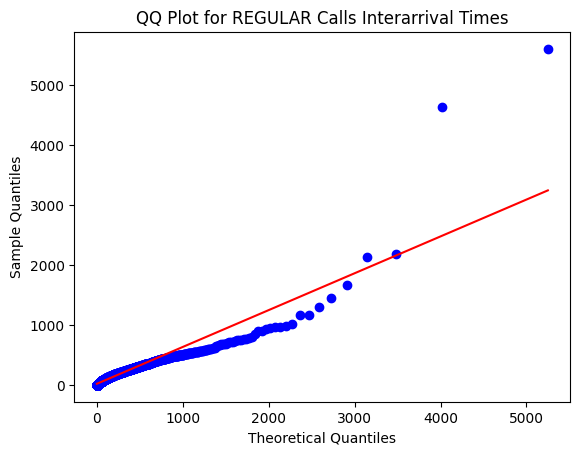

In [259]:
# QQ plots for interarrival times
qq_plot_lognorm(cc_simple_df_nozero['interarrival_time'], 'QQ Plot for REGULAR Calls Interarrival Times')

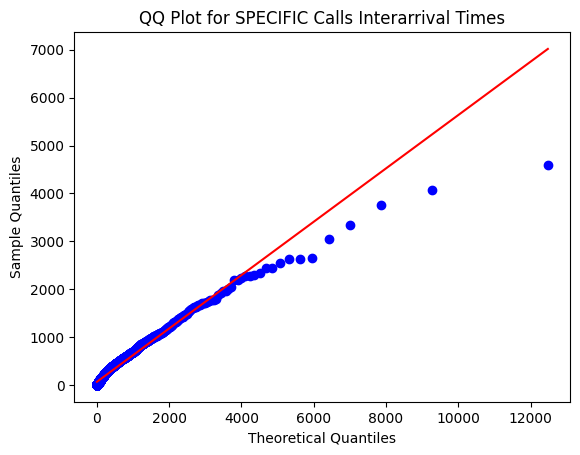

In [260]:
qq_plot_lognorm(cc_complex_df_nozero['interarrival_time'], 'QQ Plot for SPECIFIC Calls Interarrival Times')

We will decide to use lognorm and ignoring 0 interarrival values, since the record are small (1%) anyways

### Lets do the same on service time

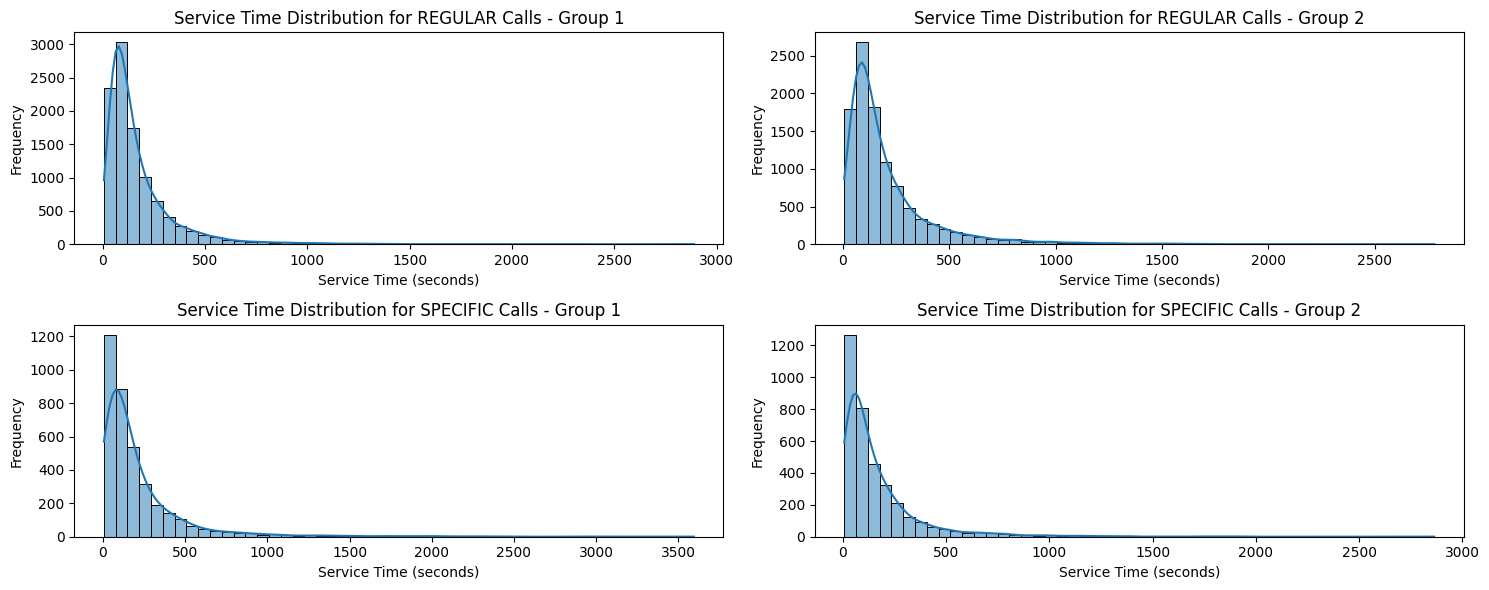

In [261]:
# Plot service time distributions for both call types and server groups
ct = ['REGULAR', 'SPECIFIC']
agents = ['1', '2']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 6))
for i, call_type in enumerate(ct):
    for j, agent in enumerate(agents):
        ax = axes[i, j]
        sns.histplot(cc_final_df[(cc_final_df['type_group'] == call_type) & (cc_final_df['group'] == agent)]['ser_time'], bins=50, kde=True, ax=ax)
        ax.set_title(f'Service Time Distribution for {call_type} Calls - Group {agent}')
        ax.set_xlabel('Service Time (seconds)')
        ax.set_ylabel('Frequency')
plt.tight_layout()
plt.show()


In [262]:
result_server_group = {}
for (group_value, type_group), group_df in cc_final_df.groupby(['group', 'type_group']):
    ser_time = group_df['ser_time']
    result_server_group[(group_value, type_group)] = ks_test_distributions_df(ser_time)
    print(f"{group_value} - {type_group}:\n", result_server_group[(group_value, type_group)], "\n")

1 - REGULAR:
              D-statistic   p-value  reject_null   best_fit
exponential     0.686188  0.000000         True  lognormal
gamma           0.983466  0.000000         True  lognormal
lognormal       0.024471  0.000009         True  lognormal
weibull         0.289046  0.000000         True  lognormal 

1 - SPECIFIC:
              D-statistic       p-value  reject_null   best_fit
exponential     0.707862  0.000000e+00         True  lognormal
gamma           0.063447  1.930717e-13         True  lognormal
lognormal       0.016138  2.850389e-01        False  lognormal
weibull         0.088251  1.284710e-25         True  lognormal 

2 - REGULAR:
              D-statistic       p-value  reject_null   best_fit
exponential     0.685037  0.000000e+00         True  lognormal
gamma           0.971556  0.000000e+00         True  lognormal
lognormal       0.026303  1.354628e-06         True  lognormal
weibull         0.091242  1.012584e-74         True  lognormal 

2 - SPECIFIC:
            

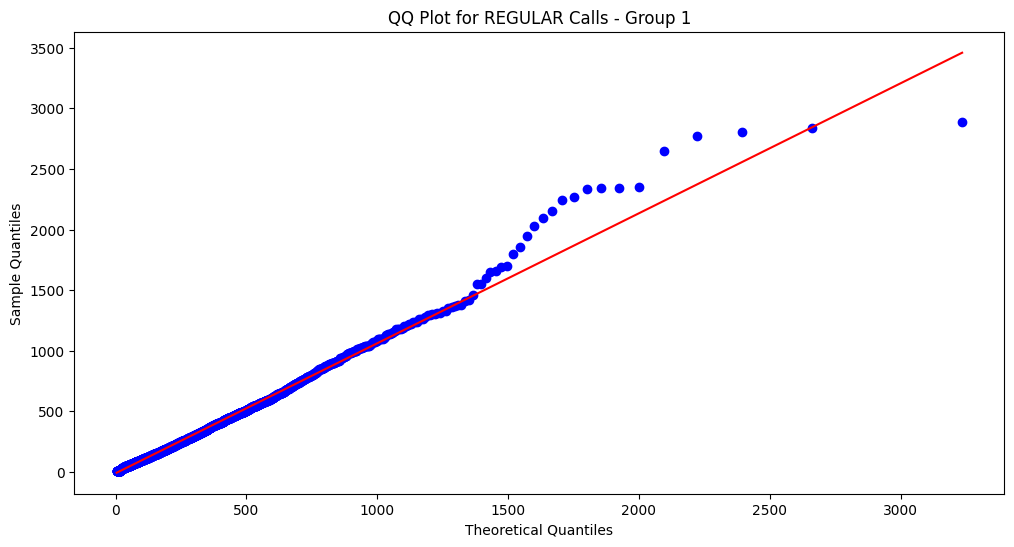

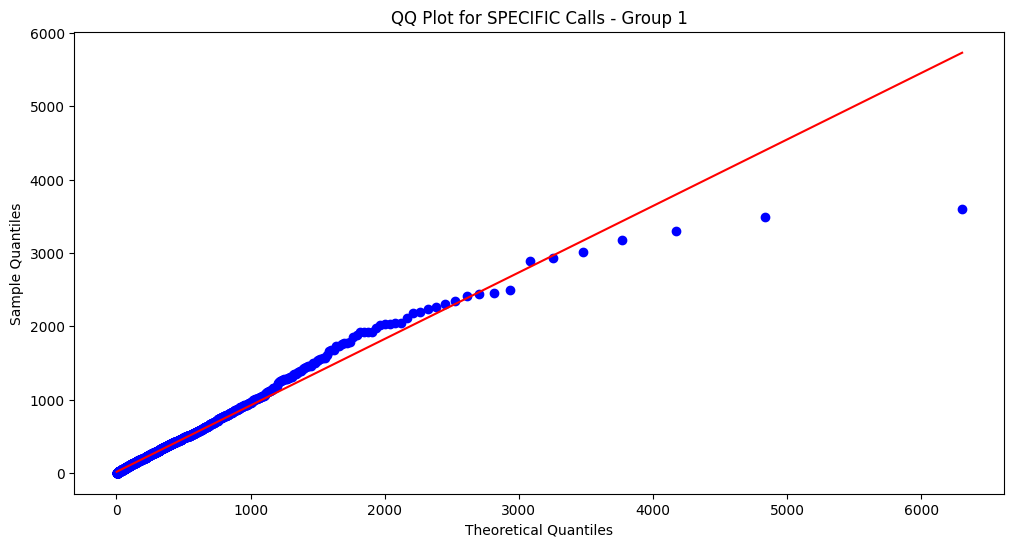

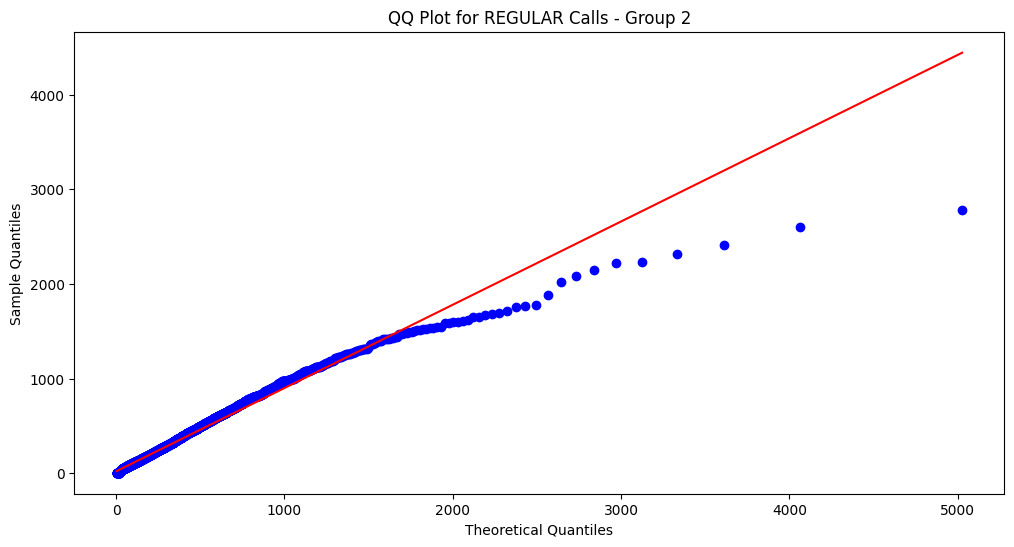

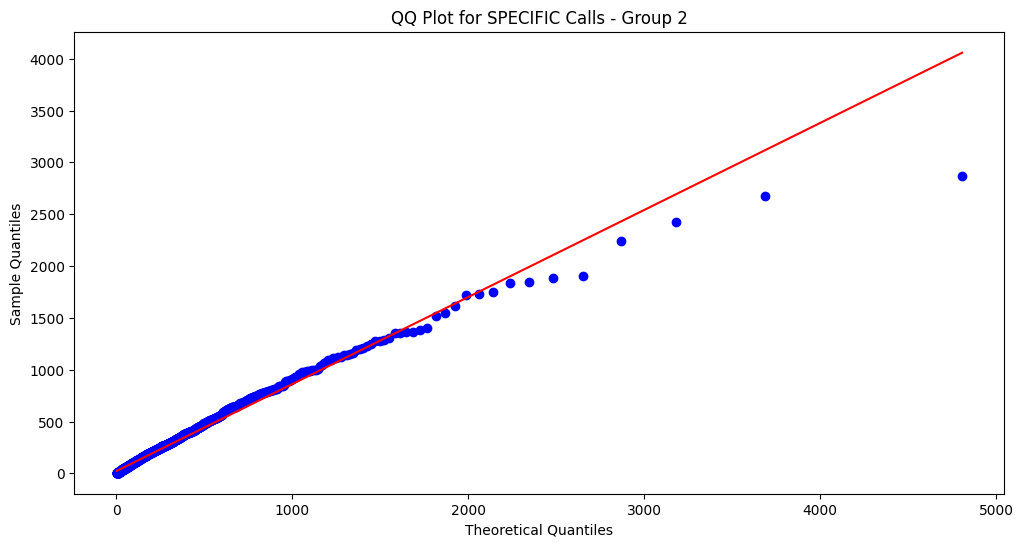

In [263]:
# Plot the service time QQ plots
for (server_group, type_group), group_df in cc_final_df.groupby(['group', 'type_group']):
    plt.figure(figsize=(12, 6))
    qq_plot_lognorm(group_df['ser_time'], f'QQ Plot for {type_group} Calls - Group {server_group}')
    plt.show()

In [264]:
# Collect the best fitting parameters for each results
best_fit_service_params = {}
for (server_group, type_group), df in result_server_group.items():
    best_fit = df['best_fit'].iloc[0]
    if best_fit == 'exponential':
        params = (df.loc['exponential', 'D-statistic'],)
    elif best_fit == 'gamma':
        params = stats.gamma.fit(cc_final_df[(cc_final_df['group'] == server_group) & (cc_final_df['type_group'] == type_group)]['ser_time'])
    elif best_fit == 'lognormal':
        params = stats.lognorm.fit(cc_final_df[(cc_final_df['group'] == server_group) & (cc_final_df['type_group'] == type_group)]['ser_time'])
    else:
        params = None
    best_fit_service_params[(server_group, type_group)] = params
    
print("Best fitting service time distribution parameters for each group and call type:")
for (server_group, type_group), params in best_fit_service_params.items():
    print(f"{server_group} - {type_group}: {params}")

Best fitting service time distribution parameters for each group and call type:
1 - REGULAR: (np.float64(0.8324764719822447), -3.115567764829924, np.float64(123.58267067008317))
1 - SPECIFIC: (np.float64(1.0752011949530333), -1.9054138290538103, np.float64(126.33203131875452))
2 - REGULAR: (np.float64(0.8540932024632348), -8.785773518703614, np.float64(148.1498746014255))
2 - SPECIFIC: (np.float64(1.0827964542219308), -1.0635409275577619, np.float64(96.9210654259884))


In [265]:
shape_simple, loc_simple, scale_simple = stats.lognorm.fit(cc_simple_df_nozero['interarrival_time'])
shape_complex, loc_complex, scale_complex = stats.lognorm.fit(cc_complex_df_nozero['interarrival_time'])

In [266]:
# Place the params in a dataframe
best_fit_params_df = pd.DataFrame.from_dict(best_fit_service_params, orient='index', columns=['shape', 'loc', 'scale'])

best_fit_params_df = best_fit_params_df.reset_index().rename(columns={'index': 'param_name'})

# Add the shape, loc, and scale for simple and complex calls
best_fit_interarrival_df = pd.DataFrame([
    {'param_name': 'REGULAR', 'shape': shape_simple, 'loc': loc_simple, 'scale': scale_simple},
    {'param_name': 'SPECIFIC', 'shape': shape_complex, 'loc': loc_complex, 'scale': scale_complex}
])

# Concatenate the best fit parameters for service times and interarrival times
best_fit_params_df = pd.concat([best_fit_params_df, best_fit_interarrival_df], ignore_index=True)

best_fit_params_df


,param_name,shape,loc,scale
0,"(1, REGULAR)",0.832476,-3.115568,123.582671
1,"(1, SPECIFIC)",1.075201,-1.905414,126.332031
2,"(2, REGULAR)",0.854093,-8.785774,148.149875
3,"(2, SPECIFIC)",1.082796,-1.063541,96.921065
4,REGULAR,1.045275,-3.064281,44.969831
5,SPECIFIC,1.120711,-5.970206,111.611433


In [267]:
# Calculate mu and sigma for lognormal distribution from the best fitting parameters
lognorm_params = {}
for _, row in best_fit_params_df.iterrows():
    param_name = row['param_name']
    scale = row['scale']
    shape = row['shape']
    mu = np.log(scale)
    sigma = np.sqrt(np.log(1 + (shape ** 2) / (scale ** 2)))
    loc = row['loc'] if 'loc' in row else 0  # Handle cases where loc is not present
    lognorm_params[param_name] = {'mu': mu, 'sigma': sigma, 'loc': loc}
    
lognorm_params_df = pd.DataFrame.from_dict(lognorm_params, orient='index').reset_index().rename(columns={'index': 'param_name'})

lognorm_params_df

,param_name,mu,sigma,loc
0,"(1, REGULAR)",4.816910,0.006736,-3.115568
1,"(1, SPECIFIC)",4.838914,0.008511,-1.905414
2,"(2, REGULAR)",4.998224,0.005765,-8.785774
3,"(2, SPECIFIC)",4.573897,0.011172,-1.063541
4,REGULAR,3.805992,0.023241,-3.064281
5,SPECIFIC,4.715023,0.010041,-5.970206


Since the `loc` is not zero, this mu and sigma is actually an approximation

In [268]:
# Save fit and lognorm param DataFrames to pickle files
best_fit_params_df.to_pickle('pickles/anonbank_best_fit_params_report.pkl')
lognorm_params_df.to_pickle('pickles/anonbank_lognorm_params_report.pkl')